# Регрессия и классификация на основе гауссовских процессов
* Документация по гауссовским процессам в библиотеке scikit-learn: http://scikit-learn.org/stable/modules/gaussian_process.html
* Материалы школы DeepBayes

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import copy

from scipy import stats
from itertools import product
from collections import Counter, defaultdict, OrderedDict
from itertools import combinations, product
from tqdm import tqdm
from pprint import pprint
import pickle as pkl

# sklearn
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge, pairwise_kernels
from sklearn.gaussian_process import GaussianProcessRegressor

from IPython.display import clear_output, display

# For animations
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

# matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize


matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['figure.figsize'] = (10, 8)    

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

$
\newcommand{\PI}{3.141592654}
\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\argmin}{\arg\min}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\Loss}{\mathcal{L}}
\newcommand{\LogLike}{\mathcal{L}}
\newcommand{\Like}{\ell}
\newcommand{\Risk}{\mathcal{R}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\avg}[1]{\left\langle #1 \right\rangle}
\newcommand{\eps}{\varepsilon}
\renewcommand{\epsilon}{\varepsilon}
\newcommand{\partfrac}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ttt}[1]{\texttt{#1}}
\newcommand{\term}[1]{\textbf{#1}}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\lf}{\left\{}
\newcommand{\rf}{\right\}}
\newcommand{\ls}{\left[}
\newcommand{\rs}{\right]}
\newcommand{\lv}{\left|}
\newcommand{\rv}{\right|}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\NN}{\mathbb{N}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\Ecdf}[1]{\hat{F}_n(#1)}
\newcommand{\OPT}{\ensuremath{\mathrm{OPT}}}
\newcommand{\opt}{\ensuremath{\mathrm{opt}}}
\newcommand{\boot}{\ensuremath{\mathrm{boot}}}
\newcommand{\bias}{\ensuremath{\mathrm{bias}}}
\newcommand{\se}{\ensuremath{\mathrm{se}}}
\newcommand{\MSE}{\ensuremath{\mathrm{MSE}}}
\newcommand{\qm}{\ensuremath{\mathrm{qm}}}
\newcommand{\as}{\ensuremath{\mathrm{as}}}
\newcommand{\trace}{\mathrm{tr}}
\newcommand{\const}{\mathrm{const}}
\newcommand{\sign}{\mathrm{sign}}
\newcommand{\tr}{\mathrm{tr}}
\newcommand{\new}{\mathrm{new}}
\newcommand{\old}{\mathrm{old}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\rank}{\mathrm{rg}}
\newcommand{\ML}{\mathrm{ML}}
\newcommand{\MP}{\mathrm{MP}}
\newcommand{\KL}{\mathrm{KL}}
\newcommand{\NV}{\mathrm{NV}}
\newcommand{\esttheta}{\hat{\theta}}
\newcommand{\estlambda}{\hat{\lambda}}
\newcommand{\estmu}{\hat{\mu}}
\newcommand{\estsigma}{\hat{\sigma}}
\newcommand{\estalpha}{\hat{\alpha}}
\newcommand{\estbeta}{\hat{\beta}}
\newcommand{\estxi}{\hat{\xi}}
\newcommand{\esttau}{\hat{\tau}}
\newcommand{\estpsi}{\hat{\psi}}
\newcommand{\esta}{\hat{a}}
\newcommand{\estb}{\hat{b}}
\newcommand{\estc}{\hat{c}}
\newcommand{\estd}{\hat{d}}
\newcommand{\estf}{\hat{f}}
\newcommand{\estp}{\hat{p}}
\newcommand{\esty}{\hat{y}}
\newcommand{\estT}{\hat{T}}
\newcommand{\estR}{\hat{R}}
\newcommand{\estF}{\hat{F}}
\newcommand{\estC}{\hat{C}}
\newcommand{\estS}{\hat{S}}
\newcommand{\estY}{\hat{Y}}
\newcommand{\estVar}{\hat{\Var}}
\newcommand{\estExp}{\hat{\Exp}}
\newcommand{\estSe}{\hat{\se}}
\newcommand{\ecdf}{\hat{F}}
\newcommand{\hata}{\hat{a}}
\newcommand{\hatb}{\hat{b}}
\newcommand{\hatc}{\hat{c}}
\newcommand{\hatd}{\hat{d}}
\newcommand{\hatf}{\hat{f}}
\newcommand{\hatg}{\hat{g}}
\newcommand{\hatk}{\hat{k}}
\newcommand{\hatp}{\hat{p}}
\newcommand{\hatr}{\hat{r}}
\newcommand{\hatt}{\hat{t}}
\newcommand{\haty}{\hat{y}}
\newcommand{\hatC}{\hat{C}}
\newcommand{\hatF}{\hat{F}}
\newcommand{\hatJ}{\hat{J}}
\newcommand{\hatK}{\hat{K}}
\newcommand{\hatY}{\hat{Y}}
\newcommand{\hateps}{\hat{\eps}}
\newcommand{\hatalpha}{\hat{\alpha}}
\newcommand{\hatbeta}{\hat{\beta}}
\newcommand{\hatpsi}{\hat{\psi}}
\newcommand{\hatlambda}{\hat{\lambda}}
\newcommand{\hattheta}{\hat{\theta}}
\newcommand{\hatsigma}{\hat{\sigma}}
\newcommand{\hatboldk}{\hat{\boldk}}
\newcommand{\hatSe}{\hat{\se}}
\newcommand{\hatExp}{\hat{\Exp}}
\newcommand{\hatVar}{\hat{\Var}}
\newcommand{\tilx}{\tilde{x}}
\newcommand{\tily}{\tilde{y}}
\newcommand{\tilX}{\tilde{X}}
\newcommand{\tilY}{\tilde{Y}}
\newcommand{\tilK}{\tilde{K}}
\newcommand{\tiltau}{\tilde{\tau}}
\newcommand{\tiltheta}{\tilde{\theta}}
\newcommand{\tillambda}{\tilde{\lambda}}
\newcommand{\tilsigma}{\tilde{\sigma}}
\newcommand{\tilpsi}{\tilde{\psi}}
\newcommand{\mlexi}{\xi_{MLE}}
\newcommand{\mletheta}{\theta_{MLE}}
\newcommand{\mlelambda}{\lambda_{MLE}}
\newcommand{\mlesigma}{\sigma_{MLE}}
\newcommand{\mlepsi}{\psi_{MLE}}
\newcommand{\mmxi}{\xi_{MM}}
\newcommand{\mmtheta}{\theta_{MM}}
\newcommand{\mmlambda}{\lambda_{MM}}
\newcommand{\mmsigma}{\sigma_{MM}}
\newcommand{\mmpsi}{\psi_{MM}}
\newcommand{\mmalpha}{\alpha_{MM}}
\newcommand{\mmbeta}{\beta_{MM}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}
\newcommand{\Dir}{\mathrm{Dir}}
\newcommand{\Beta}{\mathrm{Beta}}
\newcommand{\Family}{\mathfrak{F}}
\newcommand{\RejectRegion}{R}
\newcommand{\pvalue}{\text{p-value}}
\newcommand{\llr}{\ell}
\newcommand{\Llr}{\mathcal{L}}
\newcommand{\RRS}{\mathrm{RSS}}
\newcommand{\redtext}[1]{\textcolor{red}{#1}}
\newcommand{\addtask}[1]{\hyperref[#1]{\redtext{Задача~\ref*{#1}}}}
\newcommand{\solution}{\redtext{\textbf{Решение.}}}
\newcommand{\ignore}[1]{}
\newcommand{\NumOfSamples}{\mathcal{N}}
\newcommand{\NumOfDims}{\mathcal{D}}
\newcommand{\NumOfHidden}{\mathcal{H}}
\newcommand{\NumOfClasses}{\mathcal{K}}
\newcommand{\NumOfChannels}{\mathcal{C}}
\newcommand{\NumOfFilters}{\mathcal{F}}
\newcommand{\HiddenSize}{\mathcal{H}}
\newcommand{\bolda}{\boldsymbol{a}}
\newcommand{\boldb}{\boldsymbol{b}}
\newcommand{\bolde}{\boldsymbol{e}}
\newcommand{\boldf}{\boldsymbol{f}}
\newcommand{\boldg}{\boldsymbol{g}}
\newcommand{\boldh}{\boldsymbol{h}}
\newcommand{\boldm}{\boldsymbol{m}}
\newcommand{\boldk}{\boldsymbol{k}}
\newcommand{\bolds}{\boldsymbol{s}}
\newcommand{\boldt}{\boldsymbol{t}}
\newcommand{\boldp}{\boldsymbol{p}}
\newcommand{\boldw}{\boldsymbol{w}}
\newcommand{\boldx}{\boldsymbol{x}}
\newcommand{\boldy}{\boldsymbol{y}}
\newcommand{\boldu}{\boldsymbol{u}}
\newcommand{\boldv}{\boldsymbol{v}}
\newcommand{\boldz}{\boldsymbol{z}}
\newcommand{\boldA}{\boldsymbol{A}}
\newcommand{\boldB}{\boldsymbol{B}}
\newcommand{\boldC}{\boldsymbol{C}}
\newcommand{\boldD}{\boldsymbol{D}}
\newcommand{\boldE}{\boldsymbol{E}}
\newcommand{\boldF}{\boldsymbol{F}}
\newcommand{\boldH}{\boldsymbol{H}}
\newcommand{\boldJ}{\boldsymbol{J}}
\newcommand{\boldK}{\boldsymbol{K}}
\newcommand{\boldM}{\boldsymbol{M}}
\newcommand{\boldI}{\boldsymbol{I}}
\newcommand{\boldP}{\boldsymbol{P}}
\newcommand{\boldR}{\boldsymbol{R}}
\newcommand{\boldS}{\boldsymbol{S}}
\newcommand{\boldT}{\boldsymbol{T}}
\newcommand{\boldO}{\boldsymbol{O}}
\newcommand{\boldU}{\boldsymbol{U}}
\newcommand{\boldV}{\boldsymbol{V}}
\newcommand{\boldW}{\boldsymbol{W}}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\boldXY}{\boldsymbol{XY}}
\newcommand{\boldzero}{\boldsymbol{0}}
\newcommand{\boldalpha}{\boldsymbol{\alpha}}
\newcommand{\boldbeta}{\boldsymbol{\beta}}
\newcommand{\boldtheta}{\boldsymbol{\theta}}
\newcommand{\boldmu}{\boldsymbol{\mu}}
\newcommand{\boldxi}{\boldsymbol{\xi}}
\newcommand{\boldeta}{\boldsymbol{\eta}}
\newcommand{\boldpi}{\boldsymbol{\pi}}
\newcommand{\boldsigma}{\boldsymbol{\sigma}}
\newcommand{\boldphi}{\boldsymbol{\phi}}
\newcommand{\boldlambda}{\boldsymbol{\lambda}}
\newcommand{\boldeps}{\boldsymbol{\eps}}
\newcommand{\boldPhi}{\boldsymbol{\Phi}}
\newcommand{\boldLambda}{\boldsymbol{\Lambda}}
\newcommand{\hatboldK}{\hat{\boldK}}
\newcommand{\hatboldC}{\hat{\boldC}}
\newcommand{\hatboldy}{\hat{\boldy}}
\newcommand{\hatboldalpha}{\hat{\boldsymbol{\alpha}}}
\newcommand{\hatboldbeta}{\hat{\boldsymbol{\beta}}}
\newcommand{\hatboldtheta}{\hat{\boldsymbol{\theta}}}
\newcommand{\hatboldeps}{\hat{\boldsymbol{\eps}}}
\newcommand{\tilboldbeta}{\tilde{\boldbeta}}
\newcommand{\xs}[1]{\boldx^{(#1)}}
\newcommand{\ys}[1]{\boldy^{(#1)}}
\newcommand{\zs}[1]{\boldz^{(#1)}}
\newcommand{\Xs}[1]{\boldX^{(#1)}}
\newcommand{\Ys}[1]{\boldY^{(#1)}}
\newcommand{\Zs}[1]{\boldZ^{(#1)}}$

<a id='doe_examples'></a>
# Дизайн экспериментов [[toc]](#toc)
* [Генераторы дизайна](#doe_code_designs)
    * [Базовый дизайн](#doe_code_base_design)
    * [Производные дизайны](#doe_code_derivative_designs)
    * [Тестирование генераторов точек](#doe_design_generators_test)
* [Тестирование дизайна](#doe_code_test_design)
* [Тестовые функции](#doe_test_functions)
* [Отрисовка тестовых функций](#doe_func_plot)
    * [Классы для отрисовки тестовых функций](#doe_func_plot_classes)
    * [Фактическая отрисовка тестовых функций](#doe_func_plot_all)
* [Отрисовка дизайна эксперимента](#doe_design_plot)
    * [Классы для отрисовки дизайна экспериментов](#doe_design_plot_classes)
    * [Примеры отрисовки дизайнов](#doe_design_plot_examples)
* [Анимация эволюции дизайна](#doe_design_animation)
* [Тестирование различных дизайнов](#doe_func_test_designs)
    * [Случайный дизайн](#doe_func_test_random)
    * [Полнофакторный дизайн](#doe_func_test_full)
    * [Дизайн на основе латинских гиперкубов](#doe_func_test_lhs)
    * [Дизайн на основе оптимизированных латинских гиперкубов](#doe_func_test_olhs)
    * [Дизайн на основе гауссовской регрессии](#doe_func_test_gpr)
* [Отрисовка новых точек в GPR-дизайне](#doe_func_plot_new_gpr_points)
* [Сравнительный анализ дизайнов](#doe_func_design_analysis)
    * [Специальный класс для сравнения дизайнов](#doe_design_compare_class)
    * [Множественный запуск дизайнов](#doe_design_compare_runs)
    * [Графики зависимости ошибки от числа точек](#doe_design_compare_plots)

<a id='doe_code_designs'></a>
## Генераторы дизайна [[toc]](#toc) [[up]](#doe_examples)
* [Базовый дизайн](#doe_code_base_design)
* [Производные дизайны](#doe_code_derivative_designs)
* [Тестирование генераторов точек](#doe_design_generators_test)

Здесь 4 класса:
* Генератор равномерной сетки
* Генератор случаных равномерно распределенных точек
* Генератор латинских гиперкубов
* Генератор оптимизированных латинских гиперкубов (в качестве метрики взято минимаксное расстояние)

<a id='doe_code_base_design'></a>
### Базовый дизайн [[toc]](#toc) [[up]](#doe_code_designs)

In [16]:
import numbers

class SeedStorage:
    """
    Всякий раз, как только текущее значение seed-а было использовано для инициализации какого-либо генератора,
    его значение следует обновить, чтобы подготовить к инициализации следующего генератора. Данный класс выполняет
    выполняет именно эту задачу, по существую являясь "хранилищем" значений ключей.
    """
    def __init__(self, seed=None):
        self.seed = seed
    def __call__(self):
        if self.seed is None:
            seed = None
        else:
            seed = self.seed
            self.seed += 1
        return seed
    

class Checker:
    """
    Методы класса Checker:
    - check_type()
    - check_numeric()
    - check_int()
    - check_boolean()
    - check_positive()
    - check_nonnegative()
    - check_int_positive()
    - check_int_nonnegative()
    """
    
    
    ################################## 
    ###        Type checks         ###
    ##################################
    def _check_type(self, n, name, *types):
        if not isinstance(n, tuple(types)):
            type_names = [t.__name__ for t in types]
            raise TypeError('Param "{}" must have one of the types "{}", not "{}".'.format(
                name, type_names, type(n).__name__))
        return True
    def _check_numeric(self, n, name, msg=None):
        if not isinstance(n, numbers.Number):
            if msg is None:
                msg = 'Argument "{}" must be a number.'.format(name)
            raise TypeError(msg)
        return True 
    def _check_int(self, n, name, msg=None):
        self._check_numeric(n, name, msg=msg)
        if not n == int(n):
            if msg is None:
                msg = 'Argument "{}" must be an integer number.'.format(name)
            raise TypeError(msg)
        return True
    def _check_boolean(self, n, name, msg=None):
        if not isinstance(n, bool):
            if msg is None:
                msg = 'Argument "{}" must be a boolean value.'.format(name)
            raise TypeError(msg)
        return True
        
    ################################## 
    ###        Value checks        ###
    ##################################
    def _check_positive(self, n, name, msg=None):
        self._check_numeric(n, name, msg=msg)
        if n <= 0:
            if msg is None:
                msg = 'Argument "{}" must be a positive number.'.format(name)
            raise ValueError(msg)
        return True
    def _check_nonnegative(self, n, name, msg=None):
        self._check_numeric(n, name, msg=msg)
        if n < 0:
            if msg is None:
                msg = 'Argument "{}" must be a nonegative number.'.format(name)
            raise ValueError(msg)
        return True
        
    ################################## 
    ###    Type + value checks     ###
    ##################################
    def _check_int_positive(self, n, name, msg=None):
        self._check_int(n, name, msg)
        self._check_positive(n, name, msg)
        return True
    def _check_int_nonnegative(self, n, name, msg=None):
        self._check_int(n, name, msg)
        self._check_nonnegative(n, name, msg)
        return True

    ################################## 
    ###          Setters           ###
    ##################################  
    # Класс Checker обладает специальными методами, позволяющими не только проводить проверку некоторого 
    # значения, но и сохранять это значение в качестве аттрибута. Так как данная возможность опирается на 
    # использвание метода __setattr__, то требуется соблюдать особую осторожность, если данный метод
    # переопределен в наследнике класса Checker.
    def _set_number(self, value, name):
        self._check_numeric(value, name)
        self.__setattr__(name, value)
        
    def _set_number_positive(self, value, name):
        self._check_positive(value, name)
        self.__setattr__(name, value)
        
    def _set_number_nonegative(self, value, name):
        self._check_nonnegative(value)
        self.__setattr__(name, value)
    
    def _set_int_positive(self, value, name):
        self._check_int_positive(value, name)
        self._set_number_positive(value, name)
        
    def _set_int_nonegative(self, value, name):
        self._check_int_negative(value, name)
        self._set_number_nonegative(value, name)
      
    def _set_boolean(self, value, name):
        self._check_type(value, name, bool)
        self.__setattr__(name, value)
    

class ExperimentDesignBase(Checker):
    """
    Базовый класс для объектов-дизайнов экспериментов, далее DoE-объектов (Design of Experiment).
    
    Этапы существования DoE-объектов:
    - Создание объекта, вызов конструктора __init__. На этом этапе создается неинициализированная версия дизайна,
        т.е. не содержащая никаких точек.
    - Инициализация объекта посредством вызова функции initialize(...). На этом этапе создается первоначальное 
        множество точек. Если тип объекта дизайна не допускает дополнения дизайна новыми точками (например,
        дизайн методом латинских гиперкубов), то данное множество точек является также и конечным. У таких 
        DoE-объектов не определены функции get_next_point(...) и get_next_points(...).
    - Обновление дизайна посредством вызова функции get_next_point(...) или get_next_points(...) 
        вплоть до получения  требуемого количества точек/точности аппроксимации. Определена только 
        для дополняемых дизайнов: 
            - Дизайны, создаваемые случайным сэмплированием точек из допустимого множества.
            - Дизайны, создаваемые по методу минимизации дисперсии в модели гауссовской регрессии.
        Для каждой новой точки x во внешнем коде происходит измерение аппроксимируемой функции f(x),
        после чего, информация о новом значении заносится в дизайн посредством вызова метода update(...).
        Метод update(...) ожидает получения ровно стольких значений, сколько еще неизвестно дизайну, причем 
        эти значения могут передаваться не обязательно все вместе, а в нескольких последующих вызовах метода
        update(...).
            - Пусть при инициализации, т.е. вызове initialize(...), был создан массив размера
            (n_points, n_dim), т.е. из n_points точек размерности n_dim каждая. Тогда непосредственно после
            инициализации метод update(...) ожидает получения n_points значений. "ти значения могут быть
            переданы в нескольких последовательных вызовах метода update(...).
            - После вызова функции get_next_point() количество ожидаемых значений увеличивается на 1.
            - После вызова функции get_next_points(n_points) количество ожидаемых значений увеличивается
                на n_points.
    """
    def __init__(self, n_dim, limits, n_init_points=None, seed=None):
        """
        Аргументы:
        - n_dim: Положительное целое число. Размерность точек дизайна.
        - limits: Итерируемый объект; по умолчанию None. Диапазоны значений для каждого из n_dim измерений.
            Если None, то диапазон значений вдоль каждого измерения [0, 1].
        - seed: Зерно случайного генератора. Востребовано только для дизайнов, использующих случайность.
        - n_init_points: Размер плана эксперимента при инициализации. Данный параметр используется
            только в дополняемых дизайнах и задает размер начального множества точек в этих дизайнах.
            В фиксированных дизайнах данный параметр не используется.
        """
        self.set_n_dim(n_dim)
        self.set_limits(limits)
        self.set_seed(seed)
        self.n_init_points = n_init_points
        self._initialized = False
        
    def set_n_dim(self, n_dim):
        self._set_int_positive(n_dim, 'n_dim')
    def set_limits(self, limits=None):
        assert len(limits) == n_dim
        for (x, y) in limits:
            self._check_numeric(x, 'x')
            self._check_numeric(y, 'y')
            assert x < y
        self.limits = [(x, y) for (x, y) in limits]
    def set_seed(self, seed=None):
        self.seed_storage = SeedStorage(seed)
        
    ##################################################
    ####          Инициализация дизайна           ####
    ##################################################
    def initialize(self, n_points=None, as_array=True, *args, **kwargs):
        """
        В случае нерасширяемых дизайнов сразу же возвращает полное множество из n_points точек.
        В случае расширяемых дизайнов независимо от значения аргумента n_points возвращает множество
        из self.n_init_points точек (см. аргументы метода __init__). 
        
        Это функция может быть вызвана множество раз: каждый вызов создает новый дизайн. Однако при этом
        не происходит сброса хранилища SeedStorage, т.е. новый дизайн будет отличаться от предыдущего.
        
        Аргументы:
        - n_points: Количество точек для генерирования. 
            В случае расширяемого дизайна значение данного аргумента не принимается во внимание - 
                вместо него используется значение параметра self.n_init_points, переданного методу 
                __init__ при инициализации.
            В случае нерасширяемого дизайна данный параметр должен быть положительным целым числом
                представляющим количество затребованных точек дизайна.
        - as_array: Если True, метод вернет точки дизайна в виде массива размера (n_points, n_dim) 
            (или (self.n_init_points, n_dim)). Если False, вернет внутренний список из n_points 
            (или self.n_init_points) массивов-точек размера (n_dim,) каждая. Внимание, во втором случае
            возвращается ссылка на внутренне хранилище точек.
        
        Возвращает массив размера (n_points, n_dim) или список из n_points точек.
        """
        
        # Сбрасываем инициализацию, если вдруг объект уже был инициализован
        self._initialized = False 
        self.points = [] # Точки храним в списке для быстрого добавления методом append
        self.values = [] # Значения функций храним в списко для быстрого добавления методом append
        self._expected_update_values = 0 # Обнуляем счетчик затребованных значений функции
        
        # seed_storage в отличие от всего остального не сбрасывается
        self.seed = self.seed_storage()
        self.gen = np.random.RandomState(self.seed)
        
        # Создаем начальное множество точек
        points = self._initialize(n_points, *args, **kwargs)
        for point in points: 
            assert point.shape[0] == self.n_dim    # Проверка размерности сгенерированной точки
            self.points.append(np.array(point))
        self._expected_update_values = len(points) # Ожидаем поступления такого количества значений функции
        self._initialized = True # Дизайн инициализирован
        if as_array:
            return np.array(self.points)
        return self.points
    
    def _initialize(self, n_points=None, *args, **kwargs):
        """
        Данный метод возвращает итерируемое множество точек размерности n_dim. Например, массив
        размера (n_points, n_dim) или список длины n_points с элементами-массивами размера (n_dim,).
        """
        assert False, 'Not implemented for {}!'.format(type(self).__name__)
      
    def is_initialized(self):
        return self._initialized
    
    ##################################################
    ####    Доступ к внутренним данным дизайна    ####
    ##################################################
    def get_points(self, as_array=True):
        """
        Возвращает все текущие точки дизайна. 
        Внимание: требует инициализации DoE-объекта, т.е. предварительного вызова метода initialize(...).
        Внимание: если as_array=False, то метод возвращает ссылку на список точек дизайна.
        """
        assert self._initialized
        if as_array:
            return np.array(self.points)
        return self.points
    
    def get_values(self, as_array=True):
        """
        Возвращает список list, содержащий значения аппроксимируемой функции в первых N точках дизайна,
            где N --- количество значений, в общей сложности переданных дизайну посредством вызова
            метода update(...) за все время от момент инициализации дизайна.
        Внимание: требует инициализации DoE-объекта, т.е. предварительного вызова метода initialize(...).
        Внимание: метод возвращает ссылку на список значений функции в точках дизайна.
        """
        assert self._initialized
        if as_array:
            return np.array(self.values)
        return self.values
    def get_points_values(self, as_array=True):
        """
        Возвращает два списка list, содержащих все текущие точки дизайна и значения функции в этих точках.

        Внимание: длины списков points и values не обязаны совпадать в момент вызова данного метода.
        Внимание: метод возвращает ссылки на списки точек дизайна и значения функции в этих точках.
        """
        return self.get_points(as_array), self.get_values(as_array)
    
    ##################################################
    ####           Расширение дизайна             ####
    ##################################################
    def get_next_point(self):
        """
        Возвращает следующую точку дизайна. Эта функция должна быть переопределена только для адаптивных дизайнов.
        """
        assert self._initialized
        self._expected_update_values += 1
        assert False, 'Not implemented for class {}!'.format(type(self).__name__)
    def get_next_points(self, n_points):
        """
        Возвращает следующие n_points точек дизайна, выбранные согласно некоторой политике.
        """
        assert self._initialized
        self._expected_update_values += n_points
        assert False, 'Not implemented for class {}!'.format(type(self).__name__)
    def get_candidate_points(self):
        """
        В процессе выбора может рассматриваться множество точек, но выбрана только одна или несколько. Данный
        метод возвращает множество точек, которые были рассмотрены в процессе выбора следующей точки при вызове
        get_next_point(...) или get_next_points().
        """
        assert self._initialized
        assert False, 'Not implemented for class {}!'.format(type(self).__name__)
    
    ##################################################
    ###  Передача значений функции внутрь дизайна  ###
    ##################################################    
    def update(self, values):
        """
        Данная функция вызывает для обновления информации о значениях функции. Эта функция используется только в 
        адаптивных дизайнах.
        """
        assert self._initialized
        if len(values) > self._expected_update_values:
            raise ValueError('"update" expected no more than {} values while {} values are passed.'.format(
                self._expected_update_values, len(values)))
        for value in values:
            self.values.append(value)
        self._expected_update_values -= len(values) # Уменьшаем количество ожидаемых точек

<a id='doe_code_derivative_designs'></a>
### Производные дизайны [[toc]](#toc) [[up]](#doe_code_designs)

In [17]:
class GridDesign(ExperimentDesignBase):
    """
    Класс для создания полнофакторного плана.
    """
    def __init__(self, n_dim=2, limits=None, *args, **kwargs):
        super().__init__(n_dim=n_dim, limits=limits)
        
    def _initialize(self, n_points):
        """
        Так как GridDesign --- это нерасширямый дизайн, то 
        1) аргументы n_point должен быть целым положительным числом,
        2) данный метод должен вернуть массив/список/tuple из n_points точпек размера self.n_dim каждая.
        Для простоты будем считать, что метод возвращаем массив размера (n_points, self.n_dim). 
        Внимание, полнофакторный план подразумевает прямоугольную сетку, которую в общем случае можно составить
        не для всех чисел n_points: 16 = 4 x 4, но 17 = 17 x 1. Поэтому требуется продумать подход к составлению
        полнофакторного плана. Наиболее простой подход состоит в создании плана только для числа точек,
        являющихся степенями self.n_dim-степени некоторых целых чисел. А если вдруг требуется создать план для
        иного числа точек, то выбрасывать exception.
        """
        self._check_int_positive(n_points, 'n_points')
        # TODO: реализовать создание полнофакторного плана.
        # В конечном счете должен быть получен массив размера (n_points, self.n_dim)
        ##############################################
        
        ##############################################
        assert points.shape == (n_points, self.n_dim)
        return points
    
    
class RandomDesign(ExperimentDesignBase):
    """
    Класс для создания случайного плана
    """
    def __init__(self, n_dim=2, limits=None, seed=None, n_init_points=None, *args, **kwargs):
        """
        Явно передается n_init_pionts, так как дизайн расширяемый.
        Явно передается seed, так как дизайн случайный.
        """
        super().__init__(n_dim=n_dim, limits=limits, seed=seed, n_init_points=n_init_points)
        
    def _initialize(self, n_points):
        """
        Дизайн расширяемый. Если n_points=None, то следует использовать self.n_init_points.
        Возвращает массив размера (n_points, self.n_dim) или (self.n_init_points, self.n_dim)
        """
        # TODO: реализовать создание случайного плана
        ##############################################
        
        ##############################################
        if n_points is None:
            assert points.shape == (self.n_init_points, self.n_dim)
        else:
            assert points.shape == (n_points, self.n_dim)
        return points
    
    def get_next_point(self):
        """
        Вернуть следующую точку расширяемого дизайна. Как и остальные точки - она выбирается случайно
        в рассматриваемой области.
        """
        assert self._initialized
        # TODO: реализовать создание случайной точки
        ##############################################
        
        ##############################################
        assert next_point.shape == (self.n_dim,)
        return next_point


class LhsDesign(ExperimentDesignBase):
    """
    Класс для создания плана методом семплирования латинским гиперкубом
    """
    def __init__(self, n_dim=2, limits=None, seed=None, *args, **kwargs):
        """
        Явно передается seed, так как дизайн случайный.
        """
        super().__init__(n_dim=n_dim, limits=limits, seed=seed)
        
    def _initialize(self, n_points):
        self._check_int_positive(n_points, 'n_points')
        # TODO: реализовать создание LHS-плана.
        # В конечном счете должен быть получен массив размера (n_points, self.n_dim)
        ##############################################
        
        ##############################################
        assert points.shape == (n_points, self.n_dim)
        return points

    
class OlhsDesign(ExperimentDesignBase):
    """
    Класс для создания плана методом семплирования оптимальным латинским гиперкубом
    """
    def __init__(self, n_dim=2, limits=None, seed=None, n_restarts=10, *args, **kwargs):
        """
        Явно передается seed, так как дизайн случайный.
        n_restarts - количество перезапусков в OLHS-дизайне
        """
        super().__init__(n_dim=n_dim, limits=limits, seed=seed)
        self.n_restarts = n_restarts

    def _initialize(self, n_points):
        self._check_int_positive(n_points, 'n_points')
        # TODO: реализовать создание LHS-плана.
        # В конечном счете должен быть получен массив размера (n_points, self.n_dim)
        ##############################################
        
        ##############################################
        assert points.shape == (n_points, self.n_dim)
        return points


class GprDesign(ExperimentDesignBase):
    """
    Дизайн на основе гауссовской регрессии.
    В данном дизайне в момент инициализации, т.е. при вызове __initialize__ создается некоторое начальное
    множество точек, которое затем расширяется путем добавления новых точек, минимизирующих дисперсию
    предсказания в гауссовской регрессии. При выборе новых точек рассматривается некоторое множество кандидатов, 
    в общем случае само является случайным.
    """
    def __init__(self, n_dim=2, limits=None, seed=None, *args, **kwargs):
        """
        - n_dim:
        - limits:
        - seed: Передается явно, так как дизайн случайный.
        Можно специфицировать аргументы из args и kwargs, чтобы задать
            а) процедуру создания начального множества точек
            б) процедуру создания множества кандидатов точек, из которых затем выбирается точка с максимальной
            дисперсией предсказания
        Например, можно добавить сюда параметры alpha, random_state, n_restarts_optimizer, используемые для
        создания внутреннего объекта гауссовой регрессии.
        """
        
        super().__init__(n_dim=n_dim, limits=limits, seed=seed)
        # TODO: Можно добавлять любые необходимые параметры

    def _initialize(self, n_points, *args, **kwargs):
        """
        Дизайн расширяемый. Если n_points=None, то следует использовать self.n_init_points.
        Возвращает массив размера (n_points, self.n_dim) или (self.n_init_points, self.n_dim)
        """
        # TODO: реализовать создание случайного плана
        ##############################################
        
        ##############################################
        if n_points is None:
            assert points.shape == (self.n_init_points, self.n_dim)
        else:
            assert points.shape == (n_points, self.n_dim)
        return points
    
    def update(self, values):
        # TODO: Нужно добавить значения функции в список self.values. Кроме того, имеет
        # смысл сразу же переобучить гауссовскую регрессию на расширевшемся множестве точек.
        pass
        
    def get_next_point(self):
        assert self._initialized
        # TODO: реализовать создание случайной точки
        ##############################################
        
        ##############################################
        assert next_point.shape == (self.n_dim,)
        return next_point
    
    def predict(self, points):
        # TODO: implement prediction at "points"
        return values, stds
    
    def get_predictor(self):
        """
        Вернуть внутренний объект регрессии.
        """
        # TODO: implement
        return GPR

<a id='doe_design_generators_test'></a>
### Тестирование генераторов точек [[toc]](#toc) [[up]](#doe_code_designs)

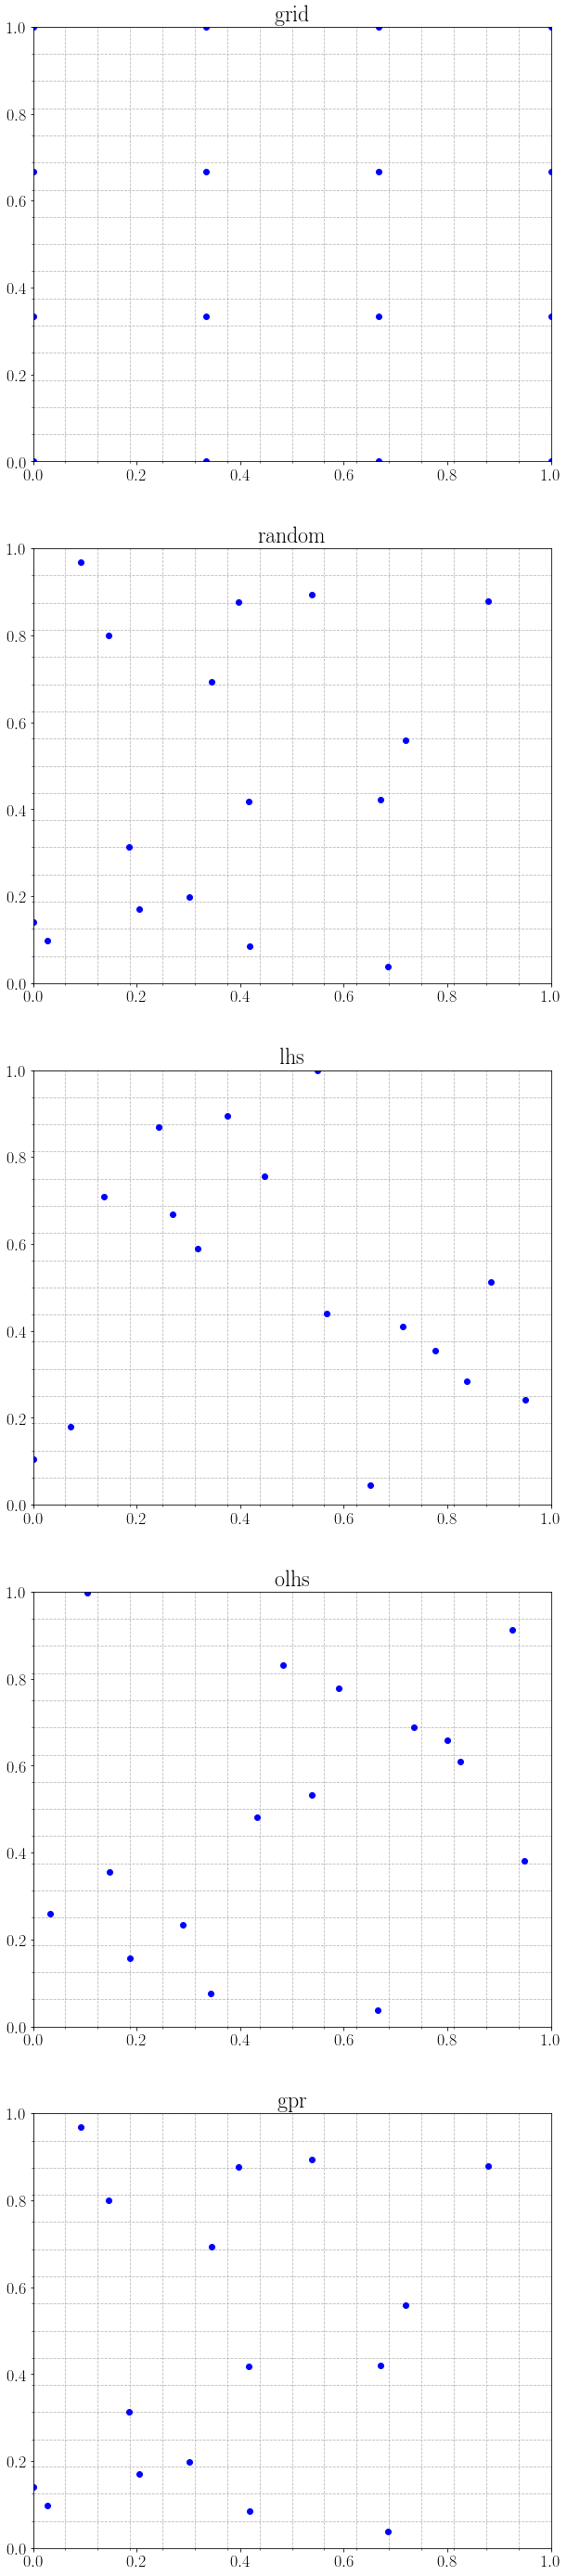

In [19]:
# Генераторы плана
x_min, x_max = 0, 1
n_dim = 2
limits = [(x_min, x_max)] * n_dim
seed = 1
designs = OrderedDict()
designs['grid']   = GridDesign(n_dim, limits, align='border')
designs['random'] = RandomDesign(n_dim, limits, seed=seed)
designs['lhs']    = LhsDesign(n_dim, limits, seed=seed)
designs['olhs']   = OlhsDesign(n_dim, limits, seed=seed)
designs['gpr']    = GprDesign(n_dim, limits, seed=seed)
n_points = 16

# Параметры отрисовки
n_cols = 1
n_rows = np.ceil(len(designs) / n_cols)
plt.figure(figsize=(10 * n_cols, 10 * n_rows))

for n_img, design_name in enumerate(designs):
    ax = plt.subplot(n_rows, n_cols, n_img + 1)
    design = designs[design_name]
    X = design.initialize(n_points)
    plt.scatter(X[:, 0], X[:, 1], color='b', zorder=2)
    plt.xlim([x_min, x_max]);
    plt.ylim([x_min, x_max]);
    ax.set_xticks(np.linspace(x_min, x_max, n_points + 1), minor=True)
    ax.set_yticks(np.linspace(x_min, x_max, n_points + 1), minor=True)
    plt.grid(which='minor', alpha=0.9, linestyle='--')
    plt.title(design_name)

<a id='doe_code_test_design'></a>
## Тестирование дизайна [[toc]](#toc) [[up]](#doe_code)

In [20]:
class DesignRunner:
    """
    Данный класс предназначен для одиночного запуска процесса создания дизайна. 
    """
    
    def __init__(self, design, function, alpha=1e-10, n_restarts_optimizer=10, random_state=1,
                 verbose=-1):
        """
        -design: Объект класса ExperimentDesignBase. 
            Один из DoE-объектов. Переданный объект должен быть не инициализирован:
            инициализация DoE-объекта (создание начального плана эксперимента) осуществляется при запуске
            процесса создания дизайна.
        -function:    Тестовая функция.
        -alpha:       Априорная дисперсии шума в гауссовской регрессии.
        -n_restarts_optimizer: 
        -random_state: Зерно случайного генератора для гауссовской регрессии.   
        -verbose:
        """
        self.set_design(design)
        self.function = function
        self.test_points, self.test_values = self.function.get_test_data(as_mesh=False)
        self.n_test_points, self.n_dim = self.test_points.shape

        # Параметры гауссовской регрессии
        self.alpha = alpha
        self.n_restarts_optimizer = n_restarts_optimizer
        self.random_state = random_state
        self.gpr_params = {'alpha': self.alpha,
                           'n_restarts_optimizer': self.n_restarts_optimizer,
                           'random_state': self.random_state}
        self.verbose = verbose

    def set_design(self, design):
        assert isinstance(design, ExperimentDesignBase)
        assert not design.is_initialized()
        self.design = design

    def __call__(self, n_points):
        mse_values = []
        n_points_range = []
        
        # Создание начальной выборки (X, Y)
        self.design_points = self.design.initialize(n_points)
        self.design_values = self.function(*[self.design_points[:, n_col] for n_col in range(self.n_dim)])
        self.design.update(self.design_values)
        
        # Оценка качества на начальной выборке
        self.gpr = GaussianProcessRegressor(**self.gpr_params).fit(self.design_points, self.design_values)
        mse = ((self.gpr.predict(self.test_points) - self.test_values) ** 2).mean()
        mse_values.append(mse)
        n_points_range.append(len(self.design_points))
        self._print(4, '\tFirst {} points generated: mse = {}'.format(len(self.design_points), mse))
        
        # Пока размер плана не достиг требуемого значения, добавляем новые точки
        while len(self.design_points) < n_points:
            next_point = self.design.get_next_point()
            next_value = self.function(*list(next_point))
            # Добавляем новую точку к уже имеющимся
            self.design.update([next_value])
            # Оцениваем качество на новой выборке
            self.design_points, self.design_values = self.design.get_points_values()
            self.gpr = GaussianProcessRegressor(**self.gpr_params).fit(self.design_points, self.design_values)
            mse = ((self.gpr.predict(self.test_points) - self.test_values) ** 2).mean()
            mse_values.append(mse)
            n_points_range.append(len(self.design_points))
            self._print(5, '\tPoint {} generated: mse = {}'.format(len(self.design_points), mse))
        self.history = {}
        self.history['mse'] = np.array(mse_values)
        self.history['n_points'] = np.array(n_points_range)
        return mse_values[-1]
    
    def get_history(self):
        return self.history
    
    def _print(self, importance, msg):
        if self.verbose >= importance:
            print(msg)

<a id='doe_test_functions'></a>
## Тестовые функции [[toc]](#toc) [[up]](#doe_examples)

In [21]:
class TestFunction(Checker):
    """
    Базовый класс для тестовой функции.
    """
    def __init__(self, n_dim, limits=None, n_dim_points=None):
        self._set_n_dim(n_dim)
        self.set_limits(limits)
        self.set_n_dim_points(n_dim_points)
        
    ################################## 
    ###          Setters           ###
    ################################## 
    def _set_n_dim(self, n_dim):
        """
        Данный метод не должен вызываться извне, поэтому сделан приватным.
        """
        self._set_int_positive(n_dim, 'n_dim')
        self._test_data_outdated = True
    def set_limits(self, limits):
        self.limits = limits
        if self.limits is None:
            self.limits = self._get_default_limits()
        assert self.n_dim == len(self.limits)
        self._test_data_outdated = True
    def set_n_dim_points(self, n_dim_points):
        self.n_dim_points = n_dim_points
        if self.n_dim_points is None:
            self.n_dim_points = self._get_default_n_dim_points()
        assert self.n_dim == len(self.n_dim_points)
        self._test_data_outdated = True
        
    ################################## 
    ###          Getters           ###
    ##################################  
    def _get_default_limits(self):
        self._not_implemented()
    def _get_default_n_dim_points(self):
        self._not_implemented()
        
    def get_n_dim(self):
        return self.n_dim
    def get_limits(self):
        return self.limits
    def get_n_dim_points(self):
        return self.n_dim_points
    def get_test_data(self, as_mesh=True):
        """
        Возвращает набор тестовых точек и истинных значений функции в данных точках. 
        Возвращаемое множество точек кэшируется, поэтому последующие вызовы, не требуют повторного вычисления
        значений функции в множестве точек.
        
        Аргументы:
        :as_mesh - Булева переменная.
        
        Возвращаемое значение зависит от значения as_mesh:
            Если True, то ...
            Если False, то ...
        """
        # Если требуемые значения уже были вычислены, то возвращаем закэшированные значения
        if not self._test_data_outdated:
            if not as_mesh:
                return self.test_points, self.test_values
            return self.XXs, self.ZZ
        # Вычисление сетки и значения функции в узлах сетки
        Xs = []
        for (x_min, x_max), n_x_points in zip(self.limits, self.n_dim_points):
            Xs.append(np.linspace(x_min, x_max, n_x_points))
        self.XXs = np.meshgrid(*Xs)
        raveled_XXs = [XX.ravel() for XX in self.XXs]
        self.test_points = np.vstack(raveled_XXs).T
        assert self.test_points.shape == (np.prod(self.n_dim_points), self.n_dim)
        self.test_values = self.__call__(*raveled_XXs)
        self.ZZ = self.test_values.reshape(self.XXs[0].shape)
        if not as_mesh:
            return self.test_points, self.test_values
        return self.XXs, self.ZZ 
    
    def __call__(self, *args):
        if len(args) == 1:
            # Точки переданы в массиве или списке
            points = args[0]
            assert isinstance(points, (np.ndarray, list, tuple))
            points = np.array(points, copy=False) # Создаем массив; не копируем без надобности
            arrays = [points[:, n_dim] for n_dim in range(self.n_dim)]
        elif len(args) == self.n_dim:
            arrays = [np.array(array) for array in args]
        else:
            raise ValueError('Passed values cannot be correctly parsed by {}.'.format(type(self).__name__))
        return self._calculate_function(*arrays)
    def _calculate_function(self, *arrays):
        self._not_implemented()
    def calculate_mse(self, points, values):
        points = np.array(points, copy=False)
        values = np.array(values, copy=False)
        assert points.shape == (np.prod(self.n_dim_points), self.n_dim)
        assert values.shape == (np.prod(self.n_dim_points),)
        Xs = [points[:, n_dim] for n_dim in range(self.n_dim)]
        true_values = self.__call__(*Xs)
        assert true_values.shape == (np.prod(self.n_dim_points),)
        return ((values - true_values)**2).mean()
        
    def _not_implemented(self):
        assert False, 'Not implemented for {}!'.format(type(self).__name__)

In [36]:
class BealeFunction(TestFunction):
    def __init__(self, limits=None, n_dim_points=None):
        super().__init__(n_dim=2, limits=limits, n_dim_points=n_dim_points)
    def _get_default_limits(self):
        return [[-4.5, 4.5], [-4.5, 4.5]]
    def _get_default_n_dim_points(self):
        return (101, 101)
    def _calculate_function(self, x1, x2):
        return (1.5 - x1 + x1 * x2)**2 + (2.25 - x1 + x1 * (x2**2))**2 + (2.625 - x1 + x1 * (x2**3))**2
        
        
class WaveFunction(TestFunction):
    def __init__(self, limits=None, n_dim_points=None):
        super().__init__(n_dim=2, limits=limits, n_dim_points=n_dim_points)
    def _get_default_limits(self):
        return [[0, 1], [0, 1]]
    def _get_default_n_dim_points(self):
        return (101, 101)
    def _calculate_function(self, x1, x2):
        return 6 + 0.25 * (2 * x2 - 5 * x1)**3 + (4 - x1**2 - x2 ** 2)**2 +\
          (1 - 3 * x1)**2 + 2 * (2 - 5 * x2)**2 + 4 * np.sin(9 * x2) +\
          5 * np.sin(9 * x1 ** 2 + 12 * x2 ** 2)

class RastriginFunction(TestFunction):
    def __init__(self, limits=None, n_dim_points=None):
        super().__init__(n_dim=2, limits=limits, n_dim_points=n_dim_points)
    def _get_default_limits(self):
        return [[-2, 2], [-2, 2]]
    def _get_default_n_dim_points(self):
        return (101, 101)
    def _calculate_function(self, x1, x2):
        return 20 - x1**2 + 10 * np.cos(2 * np.pi * x1) - x2**2 + 10 * np.cos(2 * np.pi * x2)
        
        
class GoldsteinPriceFunction(TestFunction):
    def __init__(self, limits=None, n_dim_points=None):
        super().__init__(n_dim=2, limits=limits, n_dim_points=n_dim_points)
    def _get_default_limits(self):
        return [[-2, 2], [-2, 2]]
    def _get_default_n_dim_points(self):
        return (101, 101)
    def _calculate_function(self, x1, x2):
        a = 1 + (1 + x1 + x2)**2 * (19 - 14 * x1 + 3 * x1**2 - 14 * x2 + 6 * x1 * x2 + 3 * x2**2)
        b = 30 + (2 * x1 - 3 * x2)**2 * (18 - 32 * x1 + 12 * x1 ** 2 + 48 * x2 - 36 * x1 * x2 + 27 * x2 ** 2)
        return a * b


class SphereFunction(TestFunction):
    def __init__(self, limits=None, n_dim_points=None):
        super().__init__(n_dim=2, limits=limits, n_dim_points=n_dim_points)
    def _get_default_limits(self):
        return [[-1, 1], [-1, 1]]
    def _get_default_n_dim_points(self):
        return (101, 101)
    def _calculate_function(self, x1, x2):
        return x1 ** 2 + x2 ** 2
    
    
FUNCTIONS = OrderedDict()
FUNCTIONS['beale'] = BealeFunction()
FUNCTIONS['wave'] = WaveFunction()
FUNCTIONS['rastrigin'] = RastriginFunction()
FUNCTIONS['goldstein'] = GoldsteinPriceFunction()
FUNCTIONS['sphere'] = SphereFunction()

<a id='doe_func_plot'></a>
## Отрисовка тестовых функий [[toc]](#toc) [[up]](#doe_examples)
* [Классы для отрисовки тестовых функций](#doe_func_plot_classes)
* [Фактическая отрисовка тестовых функций](#doe_func_plot_all)

<a id='doe_func_plot_classes'></a>
### Классы для отрисовки тестовых функций [[toc]](#toc) [[up]](#doe_func_plot)

In [37]:
class BasePlotter:
    def __init__(self, **kwargs):
        self.kwargs = copy.deepcopy(kwargs)
        for key, value in self.default_kwargs.items():
            self.kwargs.setdefault(key, value)
    def _append_with_defaults(self, kwargs):
        for key, value in self.kwargs.items():
            kwargs.setdefault(key, value)
        return kwargs
            
class Base2dPointsPlotter(BasePlotter):
    default_kwargs = {'s': 8, 'zorder': 3, 'color': 'k', 'marker': 'o'}
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __call__(self, ax, points, values=None, **kwargs):
        kwargs = self._append_with_defaults(copy.deepcopy(kwargs))
        return ax.scatter(points[:, 0], points[:, 1], **kwargs)
    
class Base3dPointsPlotter(BasePlotter):
    default_kwargs = {'s': 8, 'zorder': 3, 'color': 'k', 'marker': 'o', 'depthshade': 0}
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __call__(self, ax, points, values, **kwargs):
        assert isinstance(ax, Axes3D)
        kwargs = self._append_with_defaults(copy.deepcopy(kwargs))
        return ax.scatter(points[:, 0], points[:, 1], values, **kwargs)

class Base2dSurfacePlotter(BasePlotter):
    default_kwargs = {'cmap': 'gist_rainbow', 'alpha': 1.0}
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __call__(self, ax, XX, YY, ZZ, **kwargs):
        assert XX.shape == YY.shape
        assert YY.shape == ZZ.shape
        kwargs = self._append_with_defaults(copy.deepcopy(kwargs))
        ax.pcolormesh(XX, YY, ZZ, **kwargs)
        
class Base3dSurfacePlotter(BasePlotter):
    default_kwargs = {'cmap': 'gist_rainbow', 'alpha': 0.5, 
                      'cstride': 2, 'rstride': 2, 
                      'edgecolor': 'k', 'linewidth': 0.2, 
                      'antialiased': True}
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __call__(self, ax, XX, YY, ZZ, **kwargs):
        assert isinstance(ax, Axes3D)
        assert XX.shape == YY.shape
        assert YY.shape == ZZ.shape
        kwargs = self._append_with_defaults(copy.deepcopy(kwargs))
        return ax.plot_surface(XX, YY, ZZ, **kwargs)

In [38]:
class Function3dPlotter:
    def __init__(self):
        pass
    
    def plot_surface(self, ax, function, **kwargs):
        assert isinstance(ax, Axes3D)
        assert isinstance(function, TestFunction)
        (XX, YY), ZZ = function.get_test_data(as_mesh=True)
        self.base_surface_plotter = Base3dSurfacePlotter()
        self.surf = self.base_surface_plotter(ax, XX, YY, ZZ, **kwargs)
        return self.surf
    def plot_points(self, ax, points, function, **kwargs):
        assert isinstance(ax, Axes3D)
        assert isinstance(function, TestFunction)
        values = function(points)
        self.base_points_plotter = Base3dPointsPlotter()
        self.scatter = self.base_points_plotter(ax, points, values, **kwargs)
        return self.scatter

def plot_function(function, init_points=None, added_points=None, 
                  ax=None, elev=45, azim=0, figsize=(15, 10), z_range=None,
                  surface_kwargs=None, init_points_kwargs=None, added_points_kwargs=None):
    """
    
    """
    # Plotting design points
    ax_passed = True
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.gca(projection='3d')
        ax_passed = False
    
    function_plotter = Function3dPlotter()
    if surface_kwargs is None:
        surface_kwargs = {}
    surf = function_plotter.plot_surface(ax, function, **surface_kwargs)

    if init_points is not None:
        if init_points_kwargs is None:
            init_points_kwargs = {'color': 'r', 'alpha': 1, 's': 10}  
        function_plotter.plot_points(ax, init_points, function, **init_points_kwargs)
    if added_points is not None:
        if added_points_kwargs is None:
            added_points_kwargs = {'color': 'b', 'alpha': 1, 's': 10}  
        function_plotter.plot_points(ax, added_points, function, **added_points_kwargs)

    # Customize the z axis
    if z_range is not None:
        ax.set_zlim(zrange)
    #   ax.zaxis.set_major_locator(LinearLocator(10))
    #   ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Labels
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.view_init(elev=elev, azim=azim)
    
    # Add a color bar which maps values to colors.
    if not ax_passed:
        fig.colorbar(surf, shrink=0.5, aspect=5)
    return surf

<a id='doe_func_plot_all'></a>
### Фактическая отрисовка тестовых функций [[toc]](#toc) [[up]](#doe_func_plot)

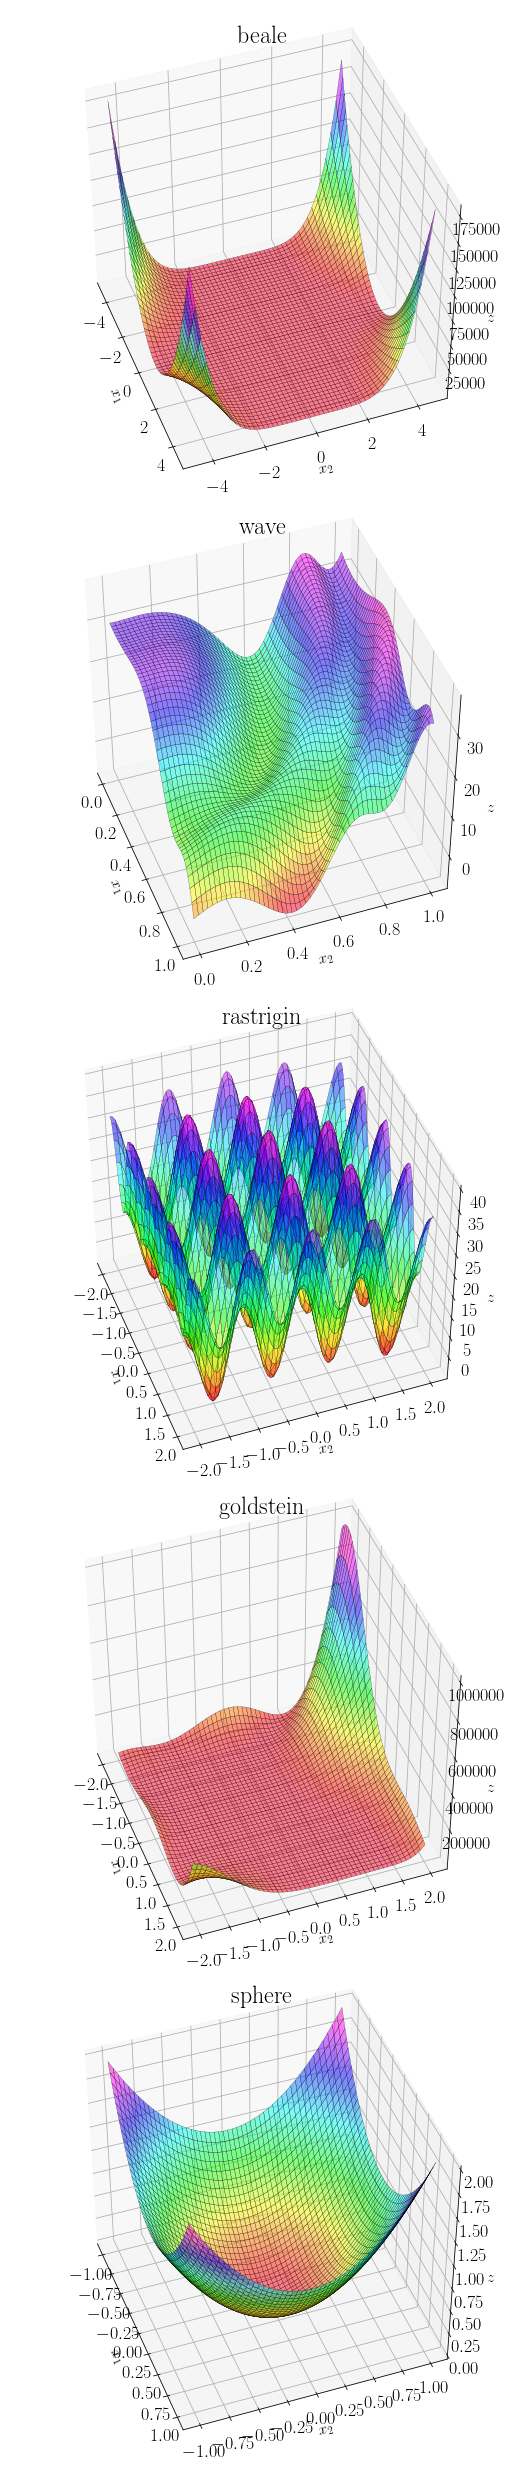

In [39]:
n_functions = len(FUNCTIONS)
axsize = 9
fig = plt.figure(figsize=(axsize, n_functions * axsize))

for n_function, function_name in enumerate(FUNCTIONS):
    function = FUNCTIONS[function_name]
    ax = fig.add_subplot(n_functions, 1, n_function + 1, projection='3d')
    plot_function(function, ax=ax, azim=-20)
    ax.set_title(function_name)

fig.subplots_adjust(wspace=0.01, hspace=0.01);

<a id='doe_design_plot'></a>
## Отрисовка дизайна эксперимента [[toc]](#toc) [[up]](#doe_examples)
* [Классы для отрисовки дизайна экспериментов](#doe_design_plot_classes)
* [Примеры отрисовки дизайнов](#doe_design_plot_examples)

<a id='doe_design_plot_classes'></a>
### Классы для отрисовки дизайна экспериментов [[toc]](#toc) [[up]](#doe_design_plot)

In [27]:
class DesignPlotterBase:
    def __init__(self, function, design, plot_true_func=False, axsize=7, vertical=False,
                 val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), 
                 func_kwargs=None,
                 stds_kwargs=None,
                 points_kwargs=None,
                 candidate_points_kwargs=None,
                 next_points_kwargs=None,
                 gpr_kwargs=None, *args, **kwargs):
        """
        Аргументы:
        :function -
        :design -
        :plot_true_func - 
        :axsize - 
        :vertical -
        :func_kwargs -
        :stds_kwargs -
        :points_kwargs -
        :candidate_points_kwargs -
        :next_points_kwargs -
        :gpr_kwargs -
        """
        
        self.plot_true_func = plot_true_func
        self.axsize = axsize
        self.vertical = vertical
        assert isinstance(function, TestFunction)
        self.function = function
        assert isinstance(design, ExperimentDesignBase)
        self.design = design
        if not self.design.is_initialized():
            raise ValueError('Design object passed to a DesignPlotter instance must be initialized!')
        
        # Создание объектов, осуществляющих отрисовку
        if func_kwargs is None: func_kwargs = {}
        if stds_kwargs is None: stds_kwargs = {}
        if points_kwargs is None: points_kwargs = {}
        if next_points_kwargs is None: next_points_kwargs = {}
        if candidate_points_kwargs is None: candidate_points_kwargs = {}
        if gpr_kwargs is None: gpr_kwargs = {}
        self.func_kwargs = copy.deepcopy(func_kwargs)
        self.stds_kwargs = copy.deepcopy(stds_kwargs)
        self.points_kwargs = copy.deepcopy(points_kwargs)
        self.next_points_kwargs = copy.deepcopy(next_points_kwargs)
        self.candidate_points_kwargs = copy.deepcopy(candidate_points_kwargs)
        self.gpr_kwargs = copy.deepcopy(gpr_kwargs)
        
        self.val_gamma = val_gamma
        self.std_gamma = std_gamma
        
        self.limits = self.function.get_limits()
        self.n_dim_points = self.function.get_n_dim_points()
        (self.xx, self.yy), self.zz = self.function.get_test_data(as_mesh=True)
        self.test_points, self.test_values = self.function.get_test_data(as_mesh=False)
        val_min = np.min(self.zz)
        val_max = np.max(self.zz)
        val_width = val_max - val_min
        self.val_min = val_min - self.val_gamma[0] * val_width
        self.val_max = val_max + self.val_gamma[1] * val_width
        
        self._axes_created = False
        self.subplot_kwargs = {}

    def _create_figure(self):
        if self._axes_created:
            return
        if self.plot_true_func:
            n_rows, n_cols = 1, 3
            if self.vertical:
                n_rows, n_cols = n_cols, n_rows
            self.fig = plt.figure(figsize=(self.axsize * n_cols, self.axsize * n_rows))
            self.ax_true_func = self.fig.add_subplot(n_rows, n_cols, 1, **self.subplot_kwargs)
            self.ax_func = self.fig.add_subplot(n_rows, n_cols, 2, **self.subplot_kwargs)
            self.ax_stds = self.fig.add_subplot(n_rows, n_cols, 3, **self.subplot_kwargs)
        else:
            self.ax_true_func = None
            n_rows, n_cols = 1, 2
            if self.vertical:
                n_rows, n_cols = n_cols, n_rows
            self.fig = plt.figure(figsize=(self.axsize * n_cols, self.axsize * n_rows))
            self.ax_func = self.fig.add_subplot(n_rows, n_cols, 1, **self.subplot_kwargs)
            self.ax_stds = self.fig.add_subplot(n_rows, n_cols, 2, **self.subplot_kwargs)
        self.fig.subplots_adjust(wspace=0.01, hspace=0.01)
        self._axes_created = True

    def get_design(self):
        return self.design
    def get_function(self):
        return self.function
    
    def plot_surface(self):
        # На всякий случай полностью очищаем графики
        self._create_figure()
        self.ax_func.clear()
        self.ax_stds.clear()
        if self.ax_true_func is not None:
            # Отрисовка истинных значений функции
            self.ax_true_func.clear()
            self.func_plotter(self.ax_true_func, self.xx, self.yy, self.zz, vmin=self.val_min, vmax=self.val_max)
            self.ax_true_func.set_xlim(self.limits[0])
            self.ax_true_func.set_ylim(self.limits[1])
            
        # Тестовые точки, значения функции и дисперсии предсказания в тестовых точках
        if hasattr(self.design, 'predict'):
            self.predictor = self.design.get_predictor()
        else:
            # Получение текущих точек дизайна
            design_points, design_values = self.design.get_points_values()
            assert len(design_points) == len(design_values)
            self.predictor = GaussianProcessRegressor(**self.gpr_kwargs).fit(design_points, design_values)
            
        test_values, test_stds = self.predictor.predict(self.test_points, return_std=True)
        test_values = test_values.reshape(self.xx.shape)
        test_stds = test_stds.reshape(self.xx.shape)

        # Значения дисперсии
        std_min = np.min(test_stds)
        std_max = np.max(test_stds)
        std_width = std_max - std_min
        std_min -= self.std_gamma[0] * std_width
        std_max += self.std_gamma[1] * std_width
        self.stds_plotter(self.ax_stds, self.xx, self.yy, test_stds, vmin=std_min, vmax=std_max)
        self.ax_stds.set_xlim(self.limits[0])
        self.ax_stds.set_ylim(self.limits[1])
        
        # Истинные значения функции
        self.func_plotter(self.ax_func, self.xx, self.yy, test_values, vmin=self.val_min, vmax=self.val_max)
        self.ax_func.set_xlim(self.limits[0])
        self.ax_func.set_ylim(self.limits[1])
 
    def plot_design_points(self):
        self._create_figure()
        design_points, design_values = self.design.get_points_values()
        _, design_stds = self.predictor.predict(design_points, return_std=True)
        self.points_plotter(self.ax_func, design_points, design_values)
        self.points_plotter(self.ax_stds, design_points, design_stds)
        if self.ax_true_func is not None:
            self.points_plotter(self.ax_true_func, design_points, design_values)

    def plot_candidate_points(self, candidate_points):
        self._create_figure()
        candidate_true_values = self.function(candidate_points)
        candidate_pred_values, candidate_pred_stds = self.predictor.predict(candidate_points, return_std=True)
        self.candidate_points_plotter(self.ax_func, candidate_points, candidate_pred_values)
        self.candidate_points_plotter(self.ax_stds, candidate_points, candidate_pred_stds)
        if self.ax_true_func is not None:
            self.candidate_points_plotter(self.ax_true_func, candidate_points, candidate_true_values)
            
    def plot_next_points(self, next_points):
        self._create_figure()
        next_true_values = self.function(next_points)
        next_pred_values, next_pred_stds = self.predictor.predict(next_points, return_std=True)
        self.next_points_plotter(self.ax_func, next_points, next_pred_values)
        self.next_points_plotter(self.ax_stds, next_points, next_pred_stds)
        if self.ax_true_func is not None:
            self.next_points_plotter(self.ax_true_func, next_points, next_true_values)
    
    
class DesignPlotter2D(DesignPlotterBase):
    def __init__(self, function, design, plot_true_func=True, axsize=7, vertical=False,
                 val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), **kwargs):
        super().__init__(function, design, plot_true_func, axsize=axsize, vertical=vertical,
                         val_gamm=val_gamma, std_gamma=std_gamma, **kwargs)
        self.func_plotter = Base2dSurfacePlotter(**self.func_kwargs)
        self.stds_plotter = Base2dSurfacePlotter(**self.stds_kwargs)
        self.points_plotter = Base2dPointsPlotter(**self.points_kwargs)
        self.next_points_plotter = Base2dPointsPlotter(**self.next_points_kwargs)
        self.candidate_points_plotter = Base2dPointsPlotter(**self.candidate_points_kwargs)
        

class DesignPlotter3D(DesignPlotterBase):
    def __init__(self, function, design, plot_true_func=True, axsize=7, vertical=True,
                 val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), elev=45, azim=0,
                 **kwargs):
        super().__init__(function, design, plot_true_func, axsize=axsize, vertical=vertical,
                         val_gamm=val_gamma, std_gamma=std_gamma, **kwargs)
        self.func_plotter = Base3dSurfacePlotter(**self.func_kwargs)
        self.stds_plotter = Base3dSurfacePlotter(**self.stds_kwargs)
        self.points_plotter = Base3dPointsPlotter(**self.points_kwargs)
        self.next_points_plotter = Base3dPointsPlotter(**self.next_points_kwargs)
        self.candidate_points_plotter = Base3dPointsPlotter(**self.candidate_points_kwargs)
        self.elev = elev
        self.azim = azim
        self.subplot_kwargs = {'projection': '3d'}
    
        
    def plot_surface(self):
        super().plot_surface()
        self.ax_true_func.view_init(elev=self.elev, azim=self.azim)
        self.ax_stds.view_init(elev=self.elev, azim=self.azim)
        if self.ax_true_func is not None:
            self.ax_func.view_init(elev=self.elev, azim=self.azim)

<a id='doe_design_plot_examples'></a>
### Примеры отрисовки дизайнов [[toc]](#toc) [[up]](#doe_design_plot)

In [28]:
func_kwargs = {'cmap': 'gist_rainbow', 'alpha': 0.5}
stds_kwargs = {'cmap': 'afmhot', 'alpha': 0.5}
points_kwargs = {'color': 'k', 'marker': 'o', 's': 36, 'zorder': 6, 'alpha': 1}
next_points_kwargs = {'color': 'm', 'marker': '*', 's': 169, 'zorder': 6, 'alpha': 1}
candidate_points_kwargs = {'color': 'r', 'marker': 'o', 's': 16, 'zorder': 6, 'alpha': 1}
gpr_kwargs = {'alpha': 1e-4, 'n_restarts_optimizer': 10, 'random_state': 0}
plotter_kwargs = {'func_kwargs': func_kwargs, 
                  'stds_kwargs': stds_kwargs,
                  'points_kwargs': points_kwargs,
                  'next_points_kwargs': next_points_kwargs,
                  'candidate_points_kwargs': candidate_points_kwargs,
                  'gpr_kwargs': gpr_kwargs}

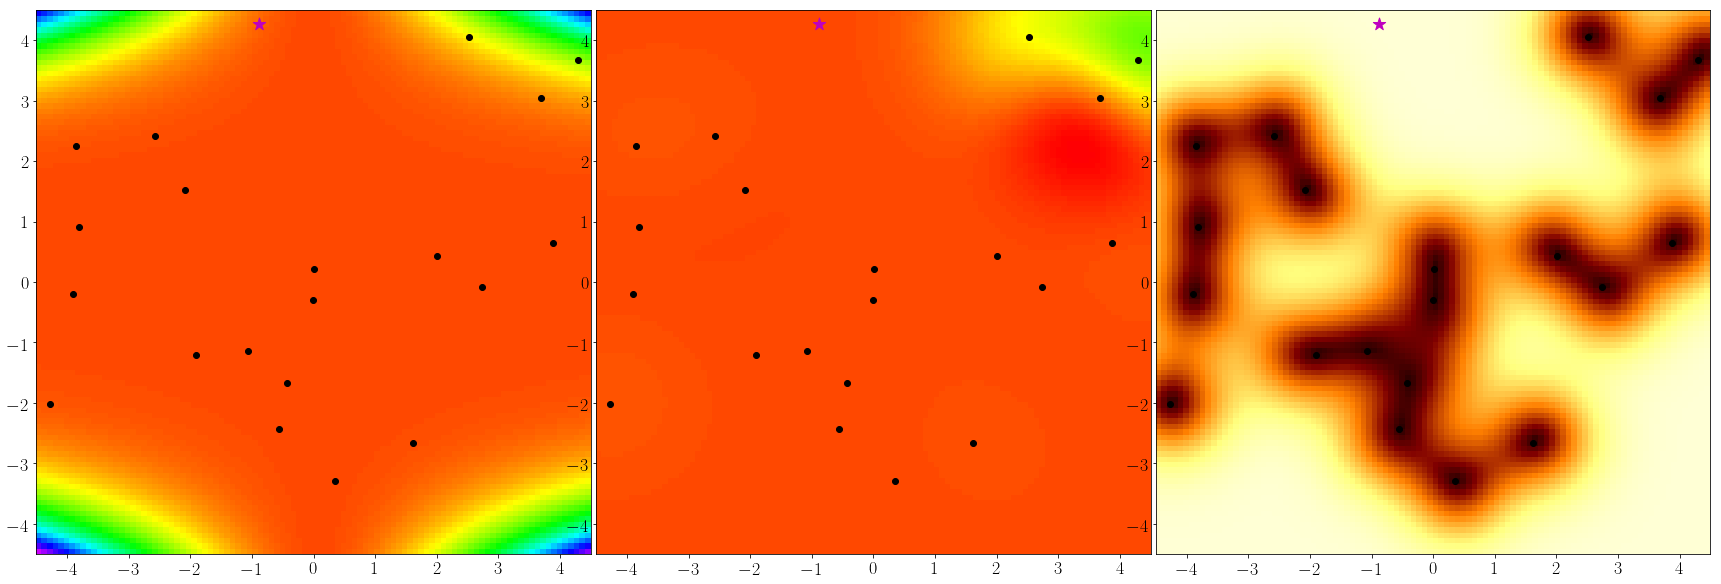

In [29]:
function_name = 'beale'
function = FUNCTIONS[function_name]

plotter_kwargs['func_kwargs']['alpha'] = 1.0
plotter_kwargs['stds_kwargs']['alpha'] = 1.0

seed = 7
n_init_points = 20
design = GprDesign(n_dim=2, limits=function.get_limits(), seed=seed, n_init_points=n_init_points, **gpr_kwargs)
design_points = design.initialize()
design_values = function(design_points)
design.update(design_values)
plotter = DesignPlotter2D(function, design, plot_true_func=True, azim=-20, 
                          val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), vertical=False, axsize=10, **plotter_kwargs);
plotter.plot_surface()
plotter.plot_design_points()
plotter.plot_next_points(design.get_next_point()[None, :])

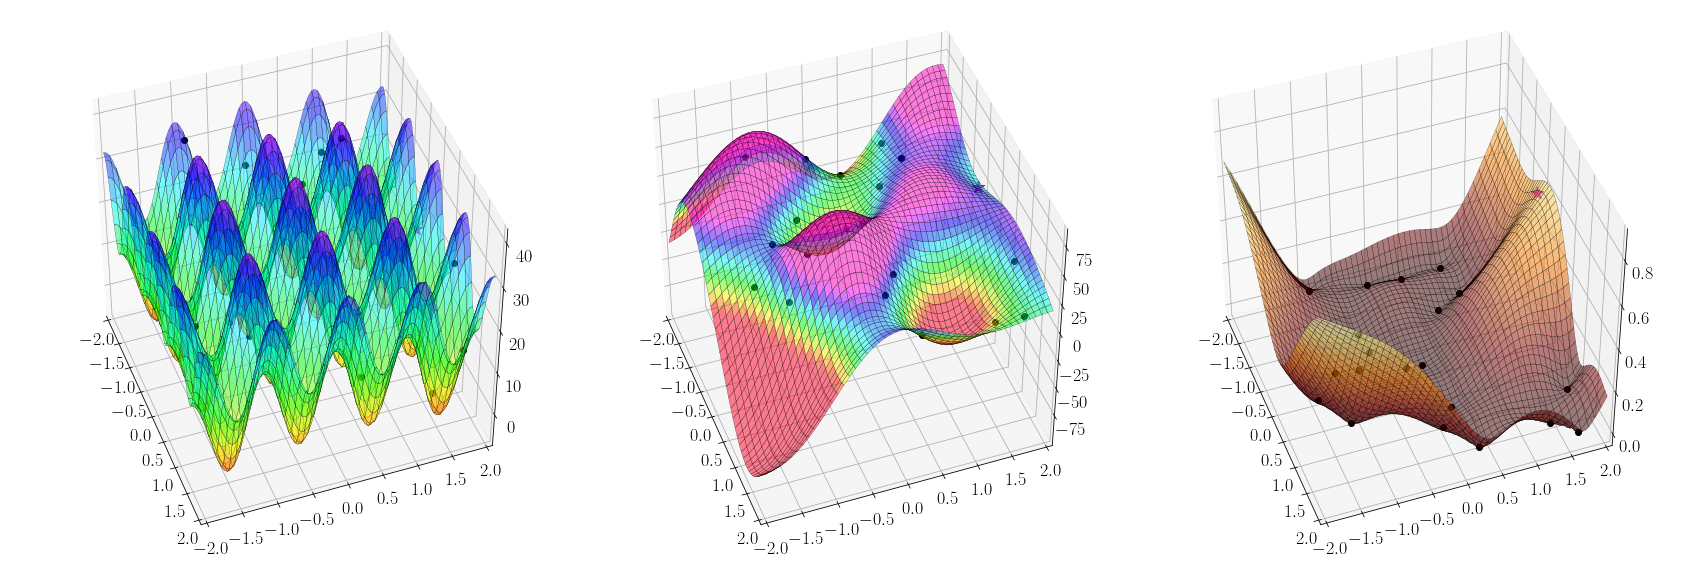

In [30]:
function_name = 'rastrigin'
function = FUNCTIONS[function_name]
plotter_kwargs['func_kwargs']['alpha'] = 0.5
plotter_kwargs['stds_kwargs']['alpha'] = 0.5


seed = 7
n_init_points = 20
design = GprDesign(n_dim=2, limits=function.get_limits(), seed=seed, n_init_points=n_init_points, **gpr_kwargs)
design_points = design.initialize()
design_values = function(design_points)
design.update(design_values)
plotter = DesignPlotter3D(function, design, plot_true_func=True, azim=-20, 
                          val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), vertical=False, axsize=10, **plotter_kwargs);
plotter.plot_surface()
plotter.plot_design_points()
plotter.plot_next_points(design.get_next_point()[None, :])

<a id='doe_design_animation'></a>
## Анимация эволюции дизайна [[toc]](#toc) [[up]](#doe_examples)

In [31]:
class DesignAnimation:
    def __init__(self, design_plotter, plot_candidates=False):
        self.design_plotter = design_plotter
        self.design = design_plotter.get_design()
        self.function = design_plotter.get_function()
        self.plot_candidates = plot_candidates
        self.n_frame = 0
        
    def __call__(self, n_frame):
        if self.n_frame % 2 == 0:
            # Полная перерисовка картины
            self.design_plotter.plot_surface()
            self.design_plotter.plot_design_points()
        else:
            next_point = self.design.get_next_point()
            next_value = self.function(next_point[None, :])[0]
            self.design.update([next_value])
            self.design_plotter.plot_next_points(next_point[None, :])
            if self.plot_candidates:
                candidate_points = self.design.get_candidate_points()
                self.design_plotter.plot_candidate_points(candidate_points)
        self.n_frame += 1
        return mplfig_to_npimage(self.design_plotter.fig)


[MoviePy] Building file beale_2d.gif with imageio


100%|█████████▉| 200/201 [00:58<00:00,  3.30it/s]


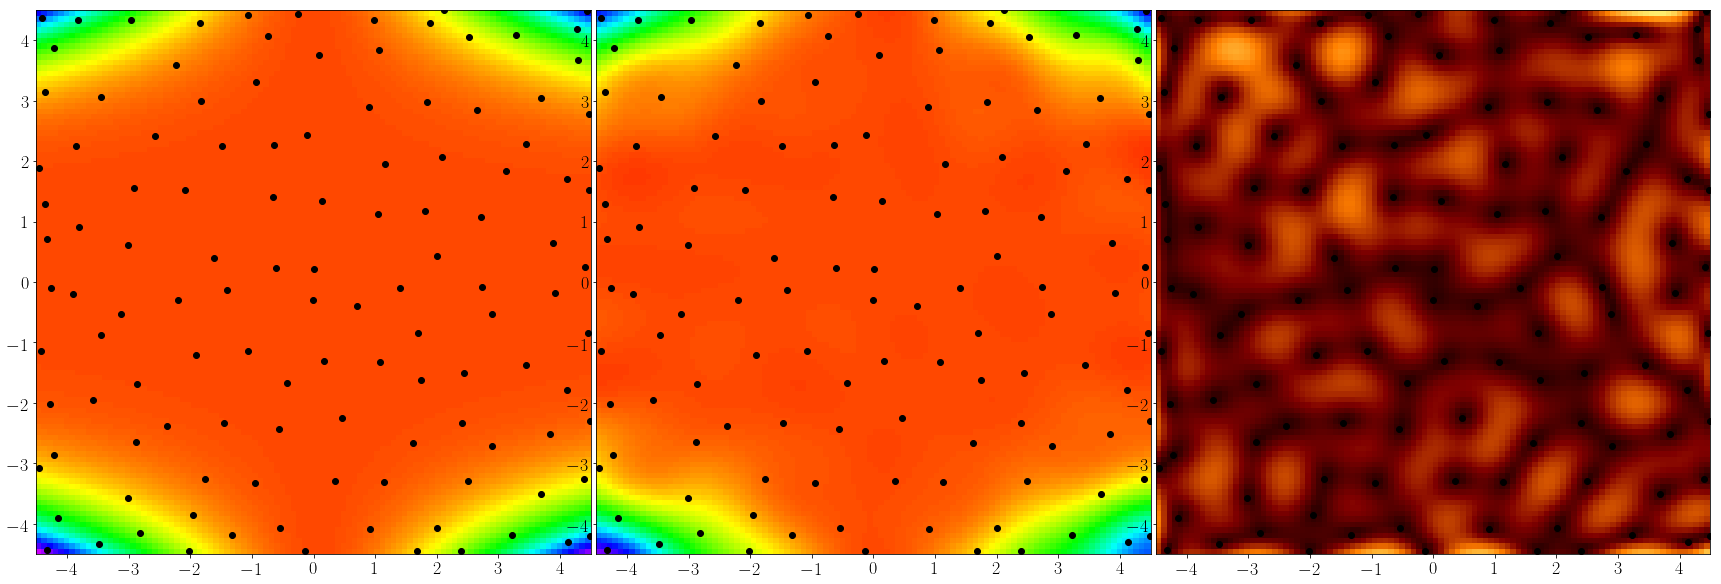

In [32]:
function_name = 'beale'
function = FUNCTIONS[function_name]
plotter_kwargs['func_kwargs']['alpha'] = 1.0
plotter_kwargs['stds_kwargs']['alpha'] = 1.0

seed = 7
n_init_points = 20
design = GprDesign(n_dim=2, limits=function.get_limits(), seed=seed, n_init_points=n_init_points, n_next_points=50,
                   **gpr_kwargs)
design_points = design.initialize()
design_values = function(design_points)
design.update(design_values)
plotter = DesignPlotter2D(function, design, plot_true_func=True, azim=-20, 
                          val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), vertical=False, axsize=10, **plotter_kwargs);
make_frame = DesignAnimation(plotter)
animation = VideoClip(make_frame, duration=50)
animation.write_gif("{}_2d.gif".format(function_name), fps=4)


[MoviePy] Building file sphere_3d.gif with imageio


100%|█████████▉| 800/801 [14:34<00:01,  1.23s/it]


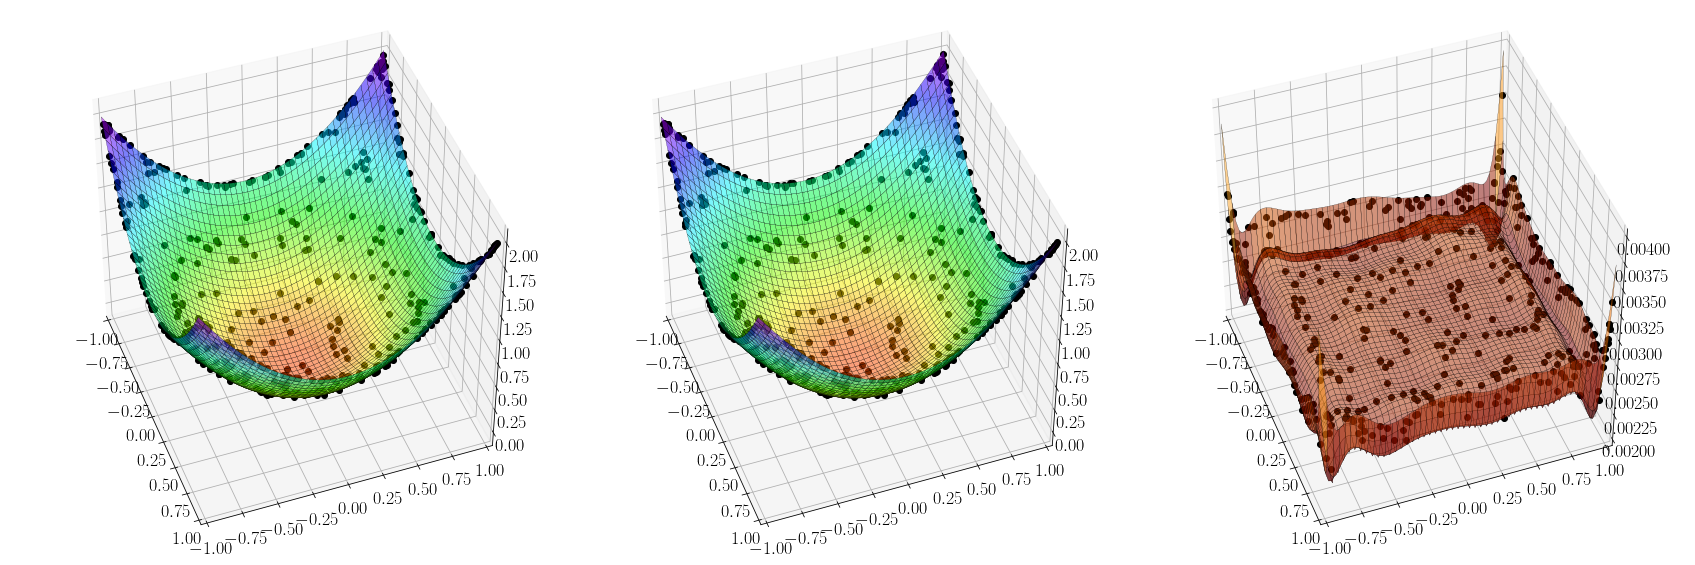

In [42]:
function_name = 'sphere'
function = FUNCTIONS[function_name]
plotter_kwargs['func_kwargs']['alpha'] = 0.5
plotter_kwargs['stds_kwargs']['alpha'] = 0.5

seed = 7
n_init_points = 20
design = GprDesign(n_dim=2, limits=function.get_limits(), seed=seed, n_init_points=n_init_points, n_next_points=50,
                   **gpr_kwargs)
design_points = design.initialize()
design_values = function(design_points)
design.update(design_values)
plotter = DesignPlotter3D(function, design, plot_true_func=True, azim=-20, 
                          val_gamma=(0.1, 0.1), std_gamma=(0.1, 0.1), vertical=False, axsize=10, **plotter_kwargs);
make_frame = DesignAnimation(plotter)
animation = VideoClip(make_frame, duration=200)
animation.write_gif("{}_3d.gif".format(function_name), fps=4)

<a id='doe_func_test_designs'></a>
## Тестирование различных дизайнов [[toc]](#toc) [[up]](#doe_examples)
* [Случайный дизайн](#doe_func_test_random)
* [Полнофакторный дизайн](#doe_func_test_full)
* [Дизайн на основе латинских гиперкубов](#doe_func_test_lhs)
* [Дизайн на основе оптимизированных латинских гиперкубов](#doe_func_test_olhs)
* [Дизайн на основе гауссовской регрессии](#doe_func_test_gpr)

Далее исползуется GaussianProcessRegressor из sklearn с почти всеми параметрами по умолчанию:
* RBF (gaussian) ядро, параметры которого подбираются по внутри самого регрессора.
* alpha = 1e-10, т.е. фактически предполагается отсутствие шума в данных (как они и есть на самом деле).
Остальные параметры уже не столь существенны.

In [66]:
func_kwargs = {'cmap': 'gist_rainbow', 'alpha': 0.5}
stds_kwargs = {'cmap': 'afmhot', 'alpha': 0.5}
points_kwargs = {'color': 'k', 'marker': 'o', 's': 36, 'zorder': 6, 'alpha': 1}
next_points_kwargs = {'color': 'm', 'marker': '*', 's': 169, 'zorder': 6, 'alpha': 1}
candidate_points_kwargs = {'color': 'r', 'marker': 'o', 's': 16, 'zorder': 6, 'alpha': 1}
gpr_kwargs = {'alpha': 1e-4, 'n_restarts_optimizer': 10, 'random_state': 0}
plotter_kwargs = {'func_kwargs': func_kwargs, 
                  'stds_kwargs': stds_kwargs,
                  'points_kwargs': points_kwargs,
                  'next_points_kwargs': next_points_kwargs,
                  'candidate_points_kwargs': candidate_points_kwargs,
                  'gpr_kwargs': gpr_kwargs}

In [67]:
function_name = 'beale'
function = FUNCTIONS[function_name]
plotter_kwargs['func_kwargs']['alpha'] = 1.0
plotter_kwargs['stds_kwargs']['alpha'] = 1.0

seed = 7
n_init_points = 20

<a id='doe_func_test_random'></a>
### Случайный дизайн [[toc]](#toc) [[up]](#doe_func_test_designs)

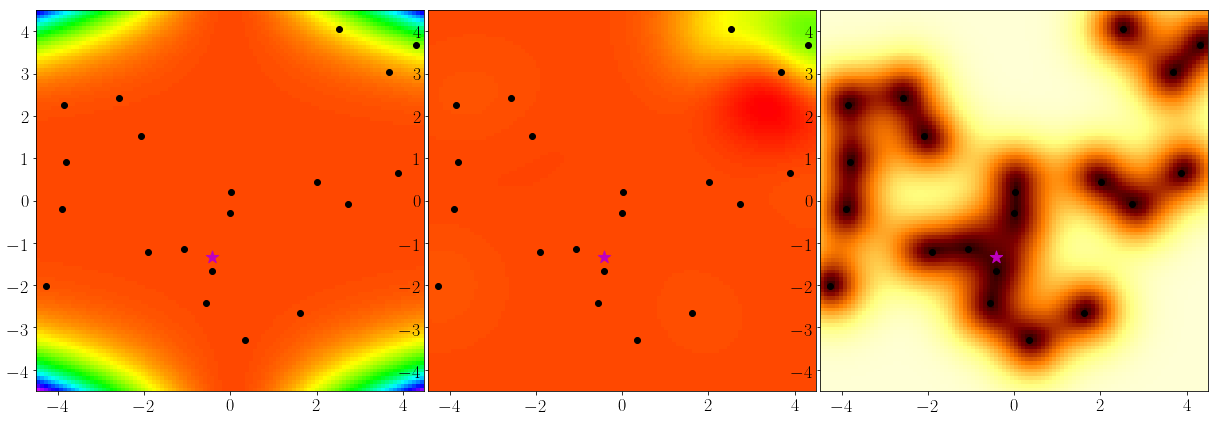

In [68]:
design = RandomDesign(n_dim, function.get_limits(), seed=seed, n_init_points=n_init_points)
points = design.initialize()
design.update(function(points[:, 0], points[:, 1]))

plotter = DesignPlotter2D(function, design, **plotter_kwargs)
plotter.plot_surface()
plotter.plot_design_points()
plotter.plot_next_points(design.get_next_point()[None, :])

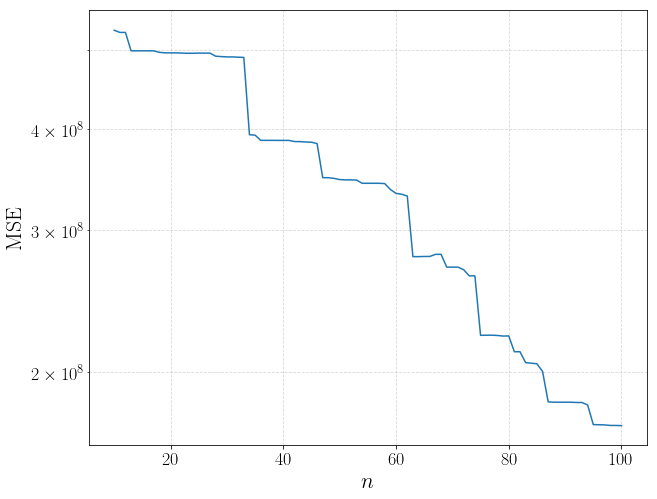

In [72]:
design = RandomDesign(n_dim, function.get_limits(), seed=seed, n_init_points=10)
runner = DesignRunner(design, function, verbose=0, **gpr_kwargs)
mse_value = runner(n_points=100)
history = runner.get_history()
mse_values = history['mse']
n_points_range = history['n_points']
plt.plot(n_points_range, mse_values)
plt.xlabel('$n$'); plt.ylabel('MSE'); plt.yscale('log')
plt.grid(which='both', linestyle='--', alpha=0.5)

<a id='doe_func_test_grid'></a>
### Полнофакторный план [[toc]](#toc) [[up]](#doe_func_test_designs)

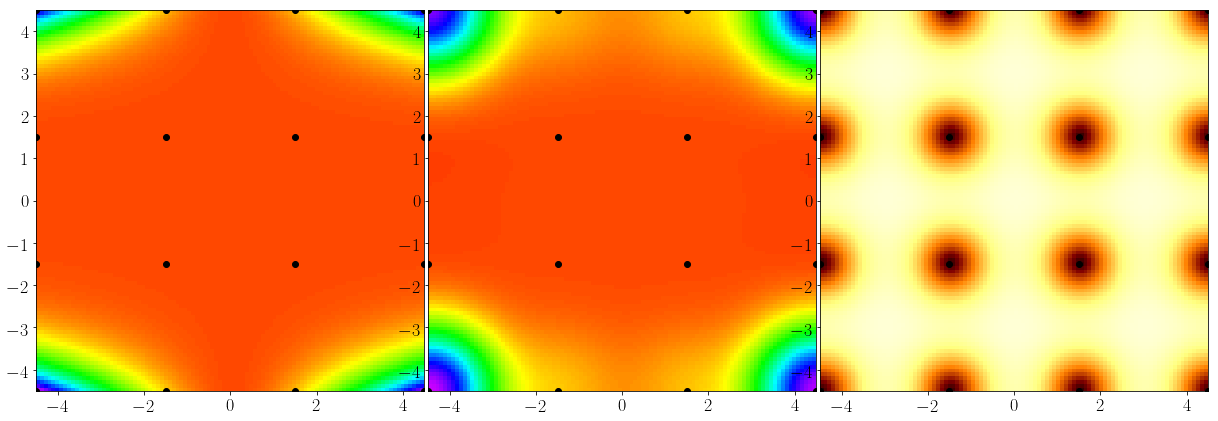

In [78]:
design = GridDesign(n_dim, function.get_limits())
points = design.initialize(n_init_points)
design.update(function(points[:, 0], points[:, 1]))
plotter = DesignPlotter2D(function, design, **plotter_kwargs)
plotter.plot_surface()
plotter.plot_design_points()

In [80]:
design = GridDesign(n_dim, function.get_limits())
runner = DesignRunner(design, function, verbose=2, **gpr_kwargs)
mse_value = runner(n_points=64)
print('MSE:', mse_value)

MSE: 87982832.53231837


<a id='doe_func_test_lhs'></a>
### Дизайн на основе латинских гиперкубов [[toc]](#toc) [[up]](#doe_func_test_designs)

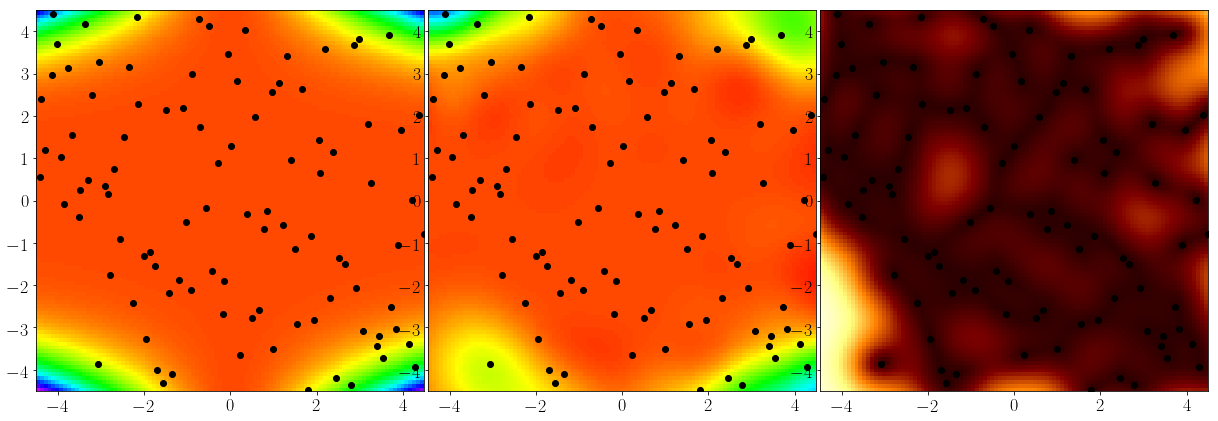

In [83]:
design = LhsDesign(n_dim, limits=function.get_limits(), seed=seed)
points = design.initialize(100)
design.update(function(points[:, 0], points[:, 1]))

plotter = DesignPlotter2D(function, design, **plotter_kwargs)
plotter.plot_surface()
plotter.plot_design_points()

In [84]:
design = LhsDesign(n_dim, limits=function.get_limits(), seed=seed)
runner = DesignRunner(design, function, verbose=1, **gpr_kwargs)
mse_value = runner(n_points=100)
print('MSE:', mse_value)

MSE: 110563959.59735948


<a id='doe_func_test_olhs'></a>
### Дизайн на основе оптимизированных латинских гиперкубов [[toc]](#toc) [[up]](#doe_func_test_designs)

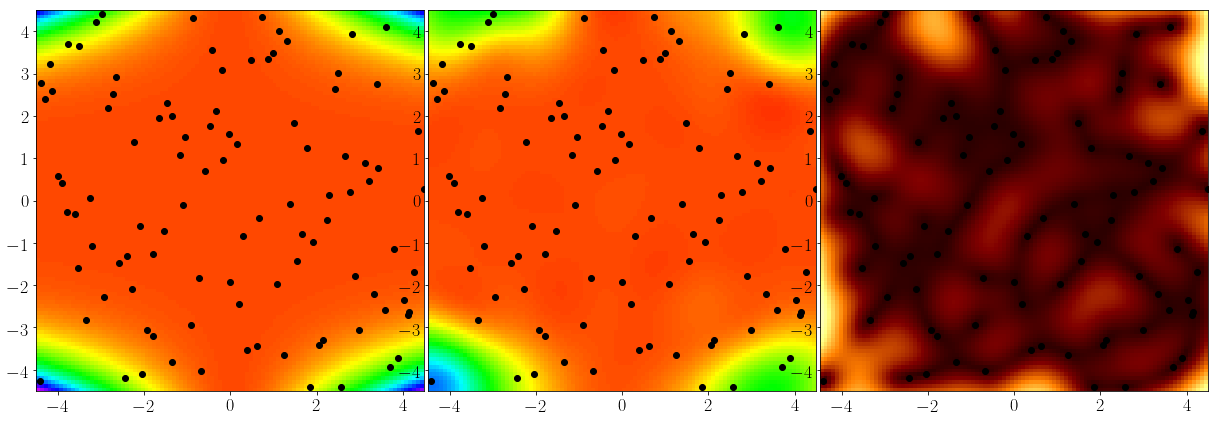

In [85]:
design = OlhsDesign(n_dim, limits=function.get_limits(), n_restarts=100, seed=seed)
points = design.initialize(100)
design.update(function(points[:, 0], points[:, 1]))

plotter = DesignPlotter2D(function, design, **plotter_kwargs)
plotter.plot_surface()
plotter.plot_design_points()

In [86]:
design = OlhsDesign(n_dim, limits=function.get_limits(), n_restarts=100, seed=seed)
runner = DesignRunner(design, function, verbose=1, **gpr_kwargs)
mse_value = runner(n_points=100)
print('MSE:', mse_value)

MSE: 87097861.51643893


<a id='doe_func_test_gpr'></a>
### Дизайн на основе гауссовской регрессии [[toc]](#toc) [[up]](#doe_func_test_designs)

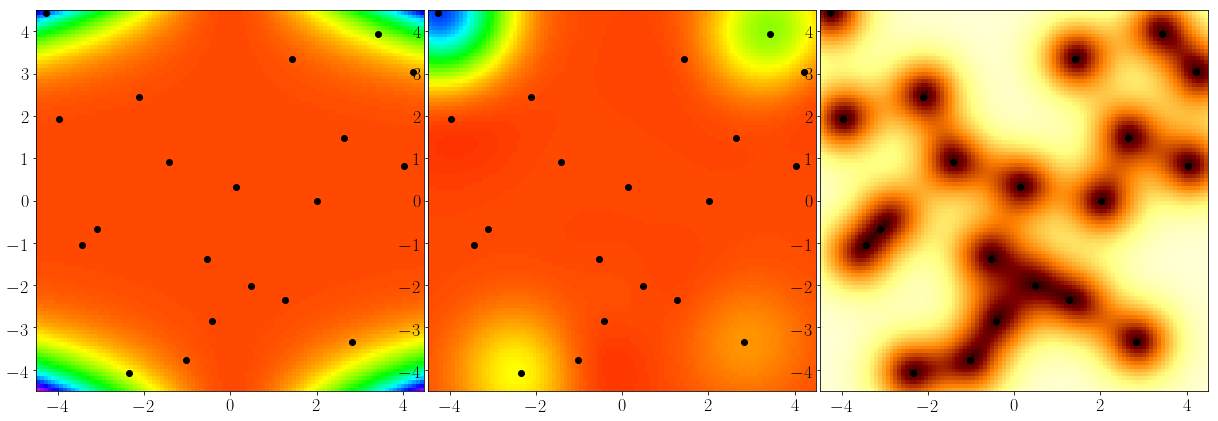

In [89]:
n_init_points = 20
design = GprDesign(n_dim, limits=function.get_limits(), 
                   init_design='olhs', n_init_points=n_init_points, 
                   n_next_points=100, **gpr_kwargs)
points = design.initialize(n_init_points)
values = function(points[:, 0], points[:, 1])
design.update(values)

plotter = DesignPlotter2D(function, design, **plotter_kwargs)
plotter.plot_surface()
plotter.plot_design_points()

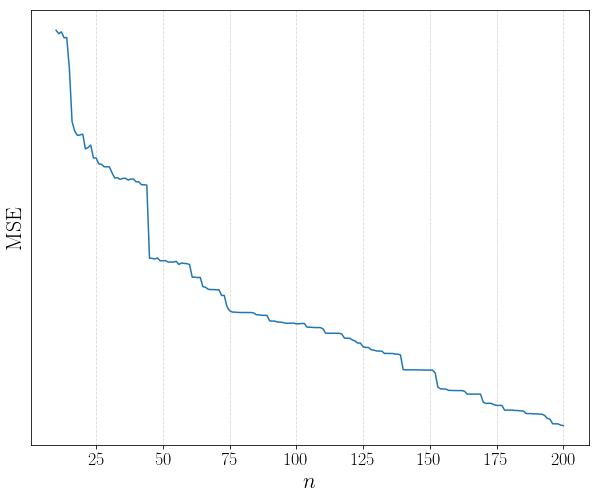

In [90]:
design = GprDesign(n_dim, limits=limits, seed=seed, 
                   init_design='random', n_init_points=10, n_next_points=10, **gpr_kwargs)
runner = DesignRunner(design, function, **gpr_kwargs)
mse_value = runner(n_points=200)
history = runner.get_history()
mse_values = history['mse']
n_points_range = history['n_points']
plt.plot(n_points_range, mse_values)
plt.xlabel('$n$'); plt.ylabel('MSE'); plt.yscale('log')
plt.grid(which='both', linestyle='--', alpha=0.5)

<a id='doe_func_plot_new_gpr_points'></a>
## Отрисовка новых точек в GPR-дизайне [[toc]](#toc) [[up]](#doe_examples)

In [123]:
seed = 7
n_init_points = 10
n_final_points = 100
design = GprDesign(n_dim=function.get_n_dim(), 
                   limits=function.get_limits(), 
                   seed=seed, init_design='random', next_design='lhs', 
                   n_init_points=n_init_points, n_next_points=20, **gpr_kwargs)
runner = DesignRunner(design, function, **gpr_kwargs)
mse_value = runner(n_points=n_final_points)
print('MSE:', mse_value)

MSE: 29967607.08430417


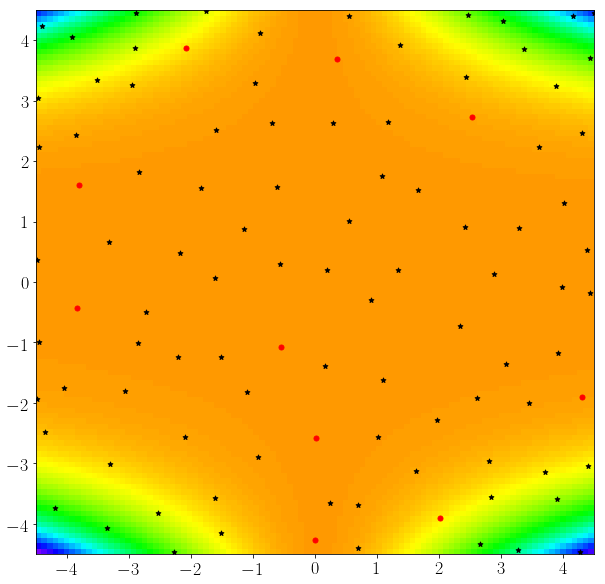

In [124]:
points, values = design.get_points_values()
limits = function.get_limits()
(xx, yy), zz = function.get_test_data(as_mesh=True)
gamma = 0.2
plt.figure(figsize=(10, 10))
vmin = np.min(zz)
vmax = np.max(zz)
plt.pcolormesh(xx, yy, zz, cmap='gist_rainbow', 
               vmin=vmin - gamma * (vmax - vmin), 
               vmax=vmax + gamma * (vmax - vmin), alpha=1)
plt.xlim(limits[0]); plt.ylim(limits[1])
plt.scatter(points[:n_init_points, 0], points[:n_init_points, 1], marker='o', color='r', label='initial', s=25);
plt.scatter(points[n_init_points:, 0], points[n_init_points:, 1], marker='*', color='k', label='added', s=25);

Как и следовало ожидать, точки концентрируются около границ рассматриваемой области. Именно за счет этого и достигается малая ошибка, так как именно на границе области функция принимает наибольшие значения.

А теперь отрисуем то же самое в 3D.

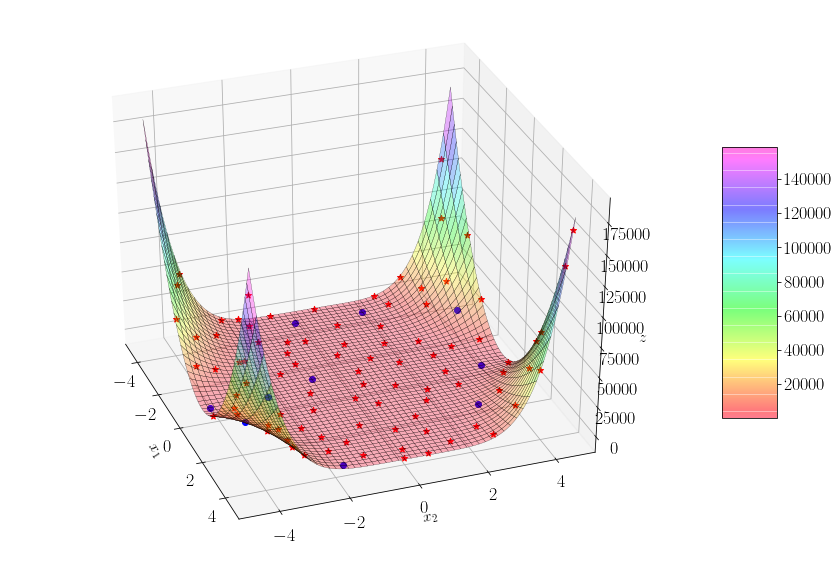

In [116]:
points = design.get_points()
n_init_points = design.n_init_points
init_points = points[:n_init_points]
added_points = points[n_init_points:]
plot_function(function, 
              init_points=init_points,
              added_points=added_points,
              surface_kwargs={'cmap': 'gist_rainbow', 'alpha': 0.3, 'cstride': 2, 'rstride': 2},
              init_points_kwargs={'color': 'b', 'marker': 'o', 's': 36},
              added_points_kwargs={'color': 'r', 'marker': '*', 's': 40},
              elev=35, azim=-20)

<a id='doe_func_design_analysis'></a>
## Сравнительный анализ дизайнов [[toc]](#toc) [[up]](#doe_examples)
* [Специальный класс для сравнения дизайнов](#doe_design_compare_class)
* [Множественный запуск дизайнов](#doe_design_compare_runs)
* [Графики зависимости ошибки от числа точек](#doe_design_compare_plots)

<a id='doe_design_compare_class'></a>
### Специальный класс для сравнения дизайнов [[toc]](#toc) [[up]](#doe_func_design_analysis)

In [91]:
class DesignComparator:
    def __init__(self, function, n_init_points, n_final_points,
                 alpha=1e-10, n_restarts_optimizer=10, random_state=None):
        self.n_init_points = n_init_points
        self.n_final_points = n_final_points
        self.n_points_range = np.array(list(range(n_init_points, n_final_points + 1)))
        self.function = function
        self.n_dim = function.get_n_dim()
        self.limits = function.get_limits()
        self.gpr_kwargs = {'alpha': alpha,
                           'n_restarts_optimizer': n_restarts_optimizer,
                           'random_state': random_state}

        
    def _get_design(self, design_name, seed=None, **design_kwargs):
        if design_name == 'lhs':
            return LhsDesign(self.n_dim, self.limits, seed=seed)
        if design_name == 'olhs':
            return OlhsDesign(self.n_dim, self.limits, seed=seed, **design_kwargs)
        if design_name == 'random':
            return RandomDesign(self.n_dim, self.limits, seed=seed, n_init_points=self.n_init_points)
        if design_name == 'grid':
            return GridDesign(self.n_dim, self.limits, **design_kwargs)
        if design_name == 'gpr':
            return GprDesign(self.n_dim, self.limits, seed=seed, n_init_points=self.n_init_points, 
                              **design_kwargs, **self.gpr_kwargs)
        assert False
        
    def __call__(self, design_name, n_runs=5, **design_kwargs):
        print('\tObtaining results for design "{}".'.format(design_name))
        if design_name == 'grid':
            n_runs = 1
            all_mse_values = []
            n_points_range = []
            for n_points in self.n_points_range:
                if n_points != round(np.sqrt(n_points)) ** 2:
                    continue
                design = self._get_design(design_name, **design_kwargs)
                test = DesignRunner(design, self.function, **self.gpr_kwargs)
                mse_value = test(n_points=n_points)
                all_mse_values.append(mse_value)
                n_points_range.append(n_points)
                print('\t\tn_points = {}, mse = {}'.format(n_points, mse_value))
            return np.array(all_mse_values)[None, :], np.array(n_points_range)
        if design_name in ['random', 'gpr']:
            all_mse_values = []
            for n_run in range(n_runs):
                mse_values = []
                design = self._get_design(design_name, seed=n_run, **design_kwargs)
                test = DesignRunner(design, self.function, **self.gpr_kwargs)
                mse_value = test(n_points=self.n_final_points)
                history = test.get_history()
                all_mse_values.append(history['mse'][None, :])
                print('\t\tn_run = {}, last mse = {}'.format(n_run, mse_value))
            all_mse_values = np.vstack(all_mse_values)
            return all_mse_values, self.n_points_range
        if design_name in ['lhs', 'olhs']:
            all_mse_values = []
            for n_run in range(n_runs):
                mse_values = []
                for n_points in self.n_points_range:
                    design = self._get_design(design_name, seed=n_run, **design_kwargs)
                    test = DesignRunner(design, self.function, **self.gpr_kwargs)
                    mse_value = test(n_points=n_points)
                    mse_values.append(mse_value)
                    #print('\t\tn_run = {}, n_points = {}, mse = {}'.format(n_run, n_points, mse_value))
                print('\t\tn_run = {}, last mse = {}'.format(n_run, mse_value))
                all_mse_values.append(np.array(mse_values)[None, :])
            all_mse_values = np.vstack(all_mse_values)
            return all_mse_values, self.n_points_range

<a id='doe_design_compare_runs'></a>
### Множественный запуск дизайнов [[toc]](#toc) [[up]](#doe_func_design_analysis)

In [99]:
import pickle as pkl

n_runs = 50
n_init_points = 10
n_final_points = 200

if os.path.isfile('RESULTS.pkl'):
    print('Loading results.')
    RESULTS = pkl.load(open('RESULTS.pkl', 'rb'))
else:
    print('Calculating results.')
    RESULTS = defaultdict(dict)
    comp = DesignComparator(function, n_init_points=n_init_points, n_final_points=n_final_points,
                            n_dim=n_dim, limits=limits, test_points=test_points, **gpr_kwargs)
    for design_name in ['grid', 'lhs', 'olhs', 'random', 'gpr']:
        mse_values, n_points_range = comp(design_name, n_runs=n_runs)
        RESULTS[design_name]['mse'] = mse_values
        RESULTS[design_name]['n_points'] = n_points_range
        pkl.dump(RESULTS, open('RESULTS.pkl', 'wb'))

Loading results.


<a id='doe_design_compare_plots'></a>
## Графики зависимости ошибки от числа точек [[toc]](#toc) [[up]](#doe_func_design_analysis)

#### Подготовка данных для построения доверительных интервалов

In [100]:
def get_bootstrap_conf_interval(theta_init, thetas_bootstrapped, alpha, conf_type='normal'):
    if conf_type == 'normal':
        z = stats.norm().ppf(1 - alpha / 2)
        theta_std = np.std(thetas_bootstrapped)
        left, right = theta_init - z * theta_std, theta_init + z * theta_std
    elif conf_type == 'pivotal':
        left = 2 * theta_init - np.percentile(thetas_bootstrapped, 100 * (1 - alpha / 2))
        right = 2 * theta_init - np.percentile(thetas_bootstrapped, 100 * (alpha / 2))
    elif conf_type == 'percentile':
        left = np.percentile(thetas_bootstrapped, 100 * alpha / 2)
        right = np.percentile(thetas_bootstrapped, 100 * (1 - alpha / 2))
    else:
        raise ValueError("Unknown type \"{}\". Choose one from the list: [normal, pivotal, percentile]".format(
            conf_type))
    return left, right

In [101]:
MEANS = {}  # Mean errors
LOWERS = {} # Upper bounds of confidence intervals
UPPERS = {} # Lower bounds of confidence intervals

bootstrap_size = 1000            # Number of bootstrapped datasets
n_samples = n_runs               # Size of a bootstrapped dataset
alpha = 0.05
np.random.seed(1)

for design_name in RESULTS:
    if design_name == 'grid':
        continue
    means = []
    lowers = []
    uppers = []
    mse_values = RESULTS[design_name]['mse']
    n_points_range = RESULTS[design_name]['n_points']
    for i in range(mse_values.shape[1]):
        n_points = n_points_range[i]
        mean_value = np.mean(mse_values[:, i])
        bootstrap_samples = np.random.choice(mse_values[:, i], bootstrap_size * n_samples)
        bootstrap_samples = bootstrap_samples.reshape((bootstrap_size, n_samples)) # bootstrapping
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        lower, upper = get_bootstrap_conf_interval(mean_value, bootstrap_means, alpha)
        lowers.append(lower)
        uppers.append(upper)
        means.append(mean_value)
    MEANS[design_name] = np.array(means)
    LOWERS[design_name] = np.array(lowers)
    UPPERS[design_name] = np.array(uppers)

Построение зависимостей с доверительными интервалалами.

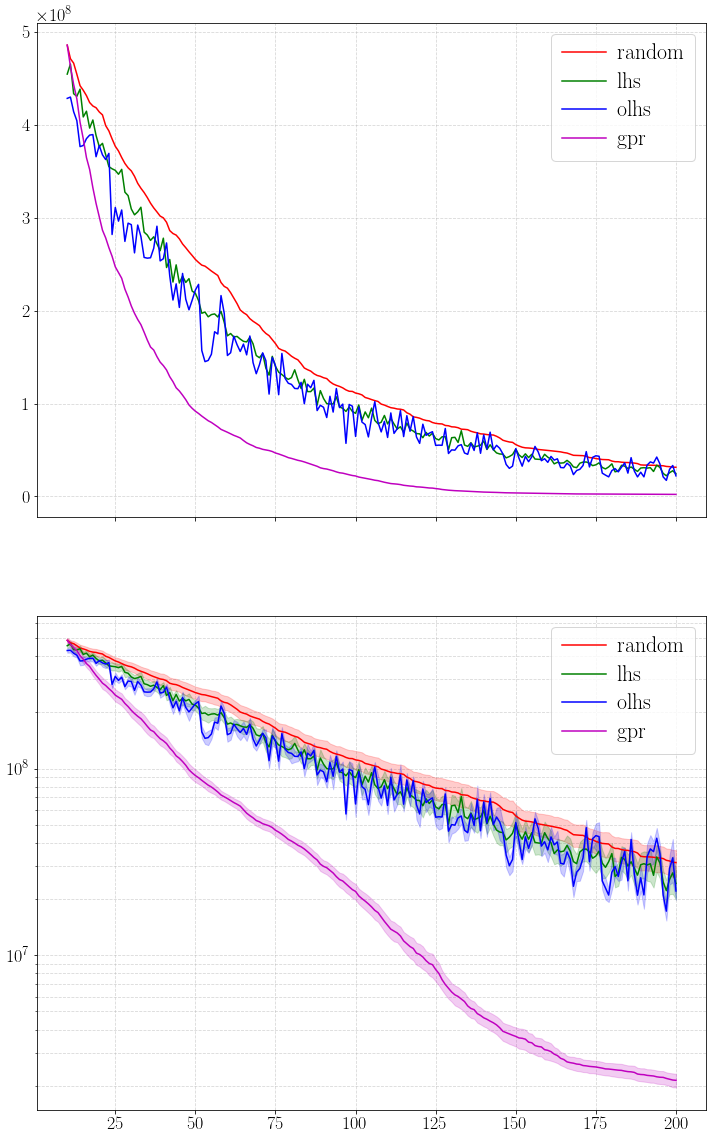

In [102]:
fig, axarr = plt.subplots(2, 1, figsize=(12, 20), sharex=True)

colors = ['r', 'g', 'b', 'm']
for n_design, design_name in enumerate(['random', 'lhs', 'olhs', 'gpr']):
    n_points_range = RESULTS[design_name]['n_points']
    for ax in axarr:
        ax.plot(n_points_range, MEANS[design_name], color=colors[n_design], label=design_name, zorder=2)
    axarr[1].fill_between(n_points_range, LOWERS[design_name], UPPERS[design_name], 
                          color=colors[n_design], alpha=0.2, zorder=2)
for ax in axarr:
    ax.legend()
    ax.grid(which='both', linestyle='--', alpha=0.5);
axarr[1].set_yscale('log')

#### Отношения величин ошибок адаптивного дизайна и OLHS к величине ошибок случайного равномерного дизайна.

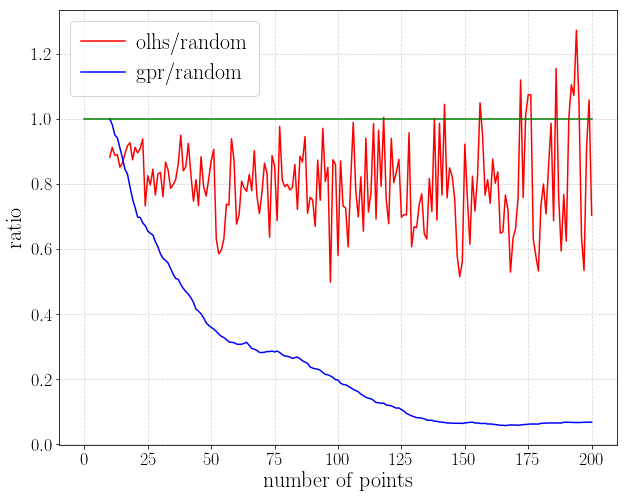

In [103]:
n_points_range = RESULTS['random']['n_points']
random_errors = np.mean(RESULTS['random']['mse'], axis=0)
olhs_errors   = np.mean(RESULTS['olhs']['mse'], axis=0)
adaptive_errors = np.mean(RESULTS['gpr']['mse'], axis=0)
plt.plot(n_points_range, olhs_errors / random_errors, label='olhs/random', color='r')
plt.plot(n_points_range, adaptive_errors / random_errors, label='gpr/random', color='b')
plt.plot([0, 200], [1, 1], color='g')
plt.grid(which='both', alpha=0.5, linestyle='--')
plt.ylabel('ratio')
plt.xlabel('number of points');
plt.legend();

Из графика видно, что адаптивный дизайн на порядки превосходит случайный равномерный дизайн. Что же касается OLHS, то данный метод в среднем ведет себя лучше случайного равномерно дизайна, однако его превосходство не столь значительно, как у адаптивного дизайна.